<a href="https://colab.research.google.com/github/fadhillahrojabhy201/Fadhillah-Rojabhy_Project1/blob/main/Project2_Fadhillah_Rojabhy_TextSummarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Dependancies

In [1]:
!pip install torch
!pip install datasets
!pip install rouge
!pip install transformers[torch]
!pip install accelerate -U
!pip install wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.9/330.9 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.34.2
    Uninstalling accelerate-0.34.2:
      Successfully uninstalled accelerate-0.34.2


# Importing the Required Libraries

In [2]:
from google.colab import drive
import os
from datasets import load_dataset, Dataset
from transformers import BertTokenizer
import torch
from transformers import BertModel, GPT2LMHeadModel, GPT2Config, EncoderDecoderModel
from torch.utils.data import DataLoader
from transformers import Trainer
from transformers import TrainingArguments
from transformers import EncoderDecoderModel, BertTokenizer, Trainer, TrainingArguments
import datasets
from transformers import pipeline
from rouge import Rouge
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import concatenate_datasets
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from textblob import TextBlob
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from sklearn.utils import resample
import torch
import os
from datasets import load_dataset, concatenate_datasets
import pandas as pd
import re
import numpy as np
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# 1. Data Preparation : Mount Google Drive

In [3]:
# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# 2. Loading the Liputan 6 Data Set

In [4]:
# Function to extract tar.gz file
def extract_tar_gz(file_path):
    os.system(f'tar -xvf {file_path}')

# Call the function with tar.gz file
extract_tar_gz('/content/drive/MyDrive/liputan6_data.tar.gz')

In [5]:
data_dir = "/content/liputan6_data"

dataset = load_dataset("id_liputan6", 'canonical', data_dir=data_dir)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.31k [00:00<?, ?B/s]

id_liputan6.py:   0%|          | 0.00/6.73k [00:00<?, ?B/s]

The repository for id_liputan6 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/id_liputan6.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating validation split:   0%|          | 0/10972 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10972 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/193883 [00:00<?, ? examples/s]

# 3. Exploratory Data Analysis

In [6]:
# Concatenate the training and test sets for a comprehensive EDA, without modifying the original dataset
full_dataset = concatenate_datasets([dataset['train'], dataset['test']])

# Convert the dataset to a pandas DataFrame
df = full_dataset.to_pandas()

## 3a. Data Cleaning, Summary and Insights

In [7]:
def clean_text(text):
    # Konversi ke Lowercase
    text = text.lower()
    # Kata berulang
    text = re.sub(r'(\w+)-\1', r'\1 \1', text)
    # Remove Specific Text
    text = re.sub(r'\([^)]*\)', '', text)  # Remove text in parentheses
    text = re.sub(r'\[[^]]*\]', '', text)  # Remove text in square brackets
    text = re.sub(r'liputan6\.com\s*[\w\s]*:', '', text)  # Remove "liputan6.com Jakarta:" and similar
    text = re.sub(r'liputan6\.com|liputan6', '', text)  # Remove remaining "liputan6.com" or "liputan6"
    # Hapus Special Characters
    text = re.sub(r'[^\w\s]', '', text)
    # Hapus Spasi Berlebih
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply cleaning to a sample of the dataset
sample_size = 1000
sample = dataset['train'].select(range(sample_size))

cleaned_articles = [clean_text(article) for article in sample['clean_article']]
cleaned_summaries = [clean_text(summary) for summary in sample['clean_summary']]

# Display a few examples
for i in range(3):
    print(f"Original Article: {sample['clean_article'][i][:100]}...")
    print(f"Cleaned Article: {cleaned_articles[i][:100]}...")
    print(f"Original Summary: {sample['clean_summary'][i][:100]}...")
    print(f"Cleaned Summary: {cleaned_summaries[i][:100]}...")
    print("\n")

# Basic statistics on cleaned text
def text_stats(texts):
    lengths = [len(text.split()) for text in texts]
    return {
        "avg_length": np.mean(lengths),
        "max_length": np.max(lengths),
        "min_length": np.min(lengths)
    }

article_stats = text_stats(cleaned_articles)
summary_stats = text_stats(cleaned_summaries)

print("Cleaned Article Statistics:")
print(article_stats)
print("\nCleaned Summary Statistics:")
print(summary_stats)

# Word frequency analysis
def get_top_words(texts, n=10):
    all_words = [word for text in texts for word in text.split()]
    return Counter(all_words).most_common(n)

print("\nTop 10 words in cleaned articles:")
print(get_top_words(cleaned_articles))

print("\nTop 10 words in cleaned summaries:")
print(get_top_words(cleaned_summaries))

Original Article: Liputan6.com, Ambon: Partai Bulan Bintang wilayah Maluku bertekad membantu pemerintah menyelesaikan ...
Cleaned Article: ambon partai bulan bintang wilayah maluku bertekad membantu pemerintah menyelesaikan konflik di prov...
Original Summary: Konflik Ambon telah berlangsung selama tiga tahun. Partai Bulan Bintang wilayah Maluku siap membantu...
Cleaned Summary: konflik ambon telah berlangsung selama tiga tahun partai bulan bintang wilayah maluku siap membantu ...


Original Article: Liputan6.com, Denpasar: Berbeda dengan sebagian besar warga di dunia, masyarakat Bali mempunyai trad...
Cleaned Article: denpasar berbeda dengan sebagian besar warga di dunia masyarakat bali mempunyai tradisi unik untuk m...
Original Summary: Masyarakat Bali merayakan Tahun Baru dengan tradisi unik dan pesta rakyat, yaitu melepas matahari 20...
Cleaned Summary: masyarakat bali merayakan tahun baru dengan tradisi unik dan pesta rakyat yaitu melepas matahari 200...


Original Article: Liputa

## 3b. Text Preprocessing

In [8]:
# Download required NLTK resources
print("Downloading required NLTK resources...")
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
print("Download completed.")

# Text cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'(\w+)-\1', r'\1 \1', text)
    text = re.sub(r'\([^)]*\)', '', text)
    text = re.sub(r'\[[^]]*\]', '', text)
    text = re.sub(r'liputan6\.com\s*[\w\s]*:', '', text)
    text = re.sub(r'liputan6\.com|liputan6', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply cleaning
df['cleaned_article'] = df['clean_article'].apply(clean_text)
df['cleaned_summary'] = df['clean_summary'].apply(clean_text)

# Text preprocessing function
stop_words = set(stopwords.words('indonesian'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = word_tokenize(text)
    processed_tokens = [lemmatizer.lemmatize(word.lower()) for word in tokens if word.lower() not in stop_words]
    return ' '.join(processed_tokens)

# Apply preprocessing
df['processed_article'] = df['cleaned_article'].apply(preprocess_text)
df['processed_summary'] = df['cleaned_summary'].apply(preprocess_text)

# Display examples
for i in range(3):
    print(f"Original Article: {df['clean_article'].iloc[i][:100]}...")
    print(f"Processed Article: {df['processed_article'].iloc[i][:100]}...")
    print(f"Original Summary: {df['clean_summary'].iloc[i][:100]}...")
    print(f"Processed Summary: {df['processed_summary'].iloc[i][:100]}...")
    print("\n")

# Text statistics
def text_stats(texts):
    lengths = [len(text.split()) for text in texts]
    return {
        "avg_length": np.mean(lengths),
        "max_length": np.max(lengths),
        "min_length": np.min(lengths)
    }

print("Processed Article Statistics:")
print(text_stats(df['processed_article']))
print("\nProcessed Summary Statistics:")
print(text_stats(df['processed_summary']))

# Word frequency analysis
def get_top_words(texts, n=10):
    all_words = [word for text in texts for word in text.split()]
    return Counter(all_words).most_common(n)

print("\nTop 10 words in processed articles:")
print(get_top_words(df['processed_article']))
print("\nTop 10 words in processed summaries:")
print(get_top_words(df['processed_summary']))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Download completed.
Original Article: Liputan6.com, Ambon: Partai Bulan Bintang wilayah Maluku bertekad membantu pemerintah menyelesaikan ...
Processed Article: ambon partai bintang wilayah maluku bertekad membantu pemerintah menyelesaikan konflik provinsi syar...
Original Summary: Konflik Ambon telah berlangsung selama tiga tahun. Partai Bulan Bintang wilayah Maluku siap membantu...
Processed Summary: konflik ambon partai bintang wilayah maluku membantu pemerintah menyelesaikan provinsi...


Original Article: Liputan6.com, Denpasar: Berbeda dengan sebagian besar warga di dunia, masyarakat Bali mempunyai trad...
Processed Article: denpasar berbeda warga dunia masyarakat bali tradisi unik menyambut pergantian tradisi menggelar upa...
Original Summary: Masyarakat Bali merayakan Tahun Baru dengan tradisi unik dan pesta rakyat, yaitu melepas matahari 20...
Processed Summary: masyarakat bali merayakan tradisi unik pesta rakyat melepas matahari 2001 menyambut matahari 2002 pa...


Original A

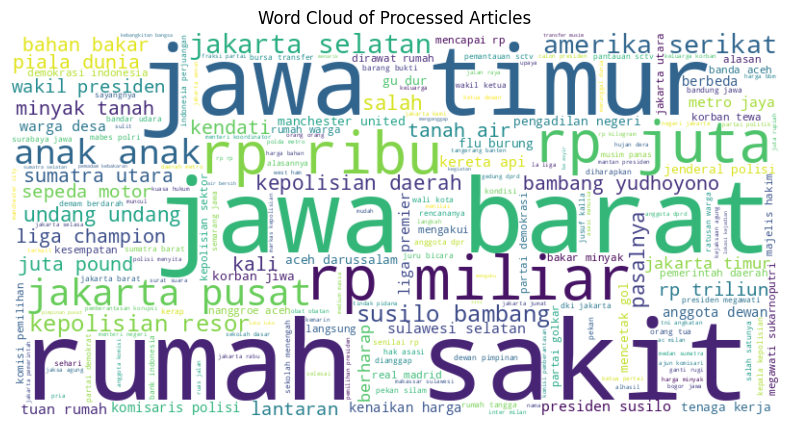

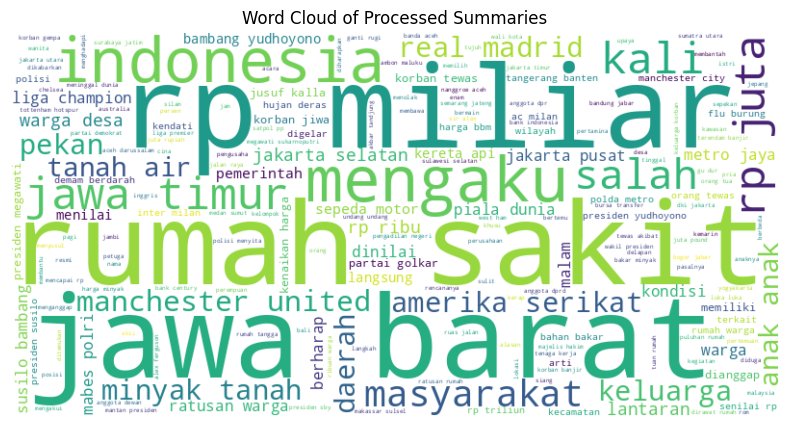

Original article vocabulary size: 612672
Processed article vocabulary size: 269388
Original summary vocabulary size: 172071
Processed summary vocabulary size: 93090


In [10]:
# Word Cloud
def create_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

create_wordcloud(' '.join(df['processed_article']), 'Word Cloud of Processed Articles')
create_wordcloud(' '.join(df['processed_summary']), 'Word Cloud of Processed Summaries')

# Unique Words Count
original_article_vocab = set(' '.join(df['clean_article']).split())
processed_article_vocab = set(' '.join(df['processed_article']).split())
original_summary_vocab = set(' '.join(df['clean_summary']).split())
processed_summary_vocab = set(' '.join(df['processed_summary']).split())

print(f"Original article vocabulary size: {len(original_article_vocab)}")
print(f"Processed article vocabulary size: {len(processed_article_vocab)}")
print(f"Original summary vocabulary size: {len(original_summary_vocab)}")
print(f"Processed summary vocabulary size: {len(processed_summary_vocab)}")

## 3c. Distribution of Article Lengths

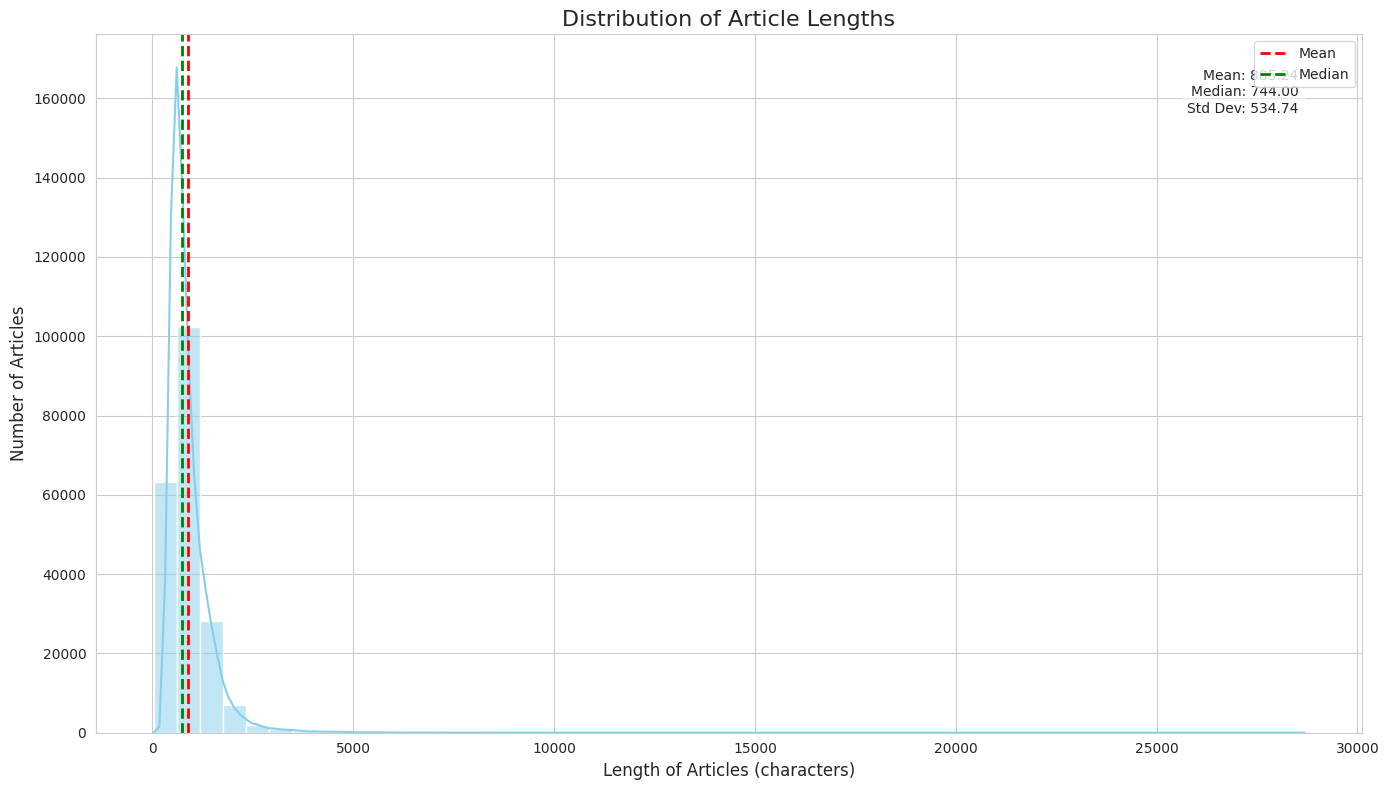

Article length statistics:
count    204855.000000
mean        885.243382
std         534.739417
min          29.000000
25%         562.000000
50%         744.000000
75%        1048.000000
max       28678.000000
Name: processed_article, dtype: float64

Skewness: 4.28
Kurtosis: 66.28
Articles longer than 5,000 characters: 267 (0.13%)
Articles shorter than 500 characters: 33416 (16.31%)

Percentiles of article lengths:
1th percentile: 312.00
5th percentile: 391.00
10th percentile: 446.00
25th percentile: 562.00
50th percentile: 744.00
75th percentile: 1048.00
90th percentile: 1471.00
95th percentile: 1783.00
99th percentile: 2870.46

Proportion of articles at max length (28678 characters): 0.00%


In [12]:
# Calculate article lengths
article_lengths = df['processed_article'].str.len()

# Plot distribution of article lengths
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")
sns.histplot(article_lengths, bins=50, kde=True, color='skyblue')
plt.axvline(article_lengths.mean(), color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(article_lengths.median(), color='green', linestyle='dashed', linewidth=2, label='Median')
stats = article_lengths.describe()
plt.text(0.95, 0.95, f"Mean: {stats['mean']:.2f}\nMedian: {stats['50%']:.2f}\nStd Dev: {stats['std']:.2f}",
         transform=plt.gca().transAxes, va='top', ha='right', bbox=dict(facecolor='white', alpha=0.5))
plt.title('Distribution of Article Lengths', fontsize=16)
plt.xlabel('Length of Articles (characters)', fontsize=12)
plt.ylabel('Number of Articles', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

# Print detailed statistics for articles
print("Article length statistics:")
print(article_lengths.describe())
print(f"\nSkewness: {article_lengths.skew():.2f}")
print(f"Kurtosis: {article_lengths.kurtosis():.2f}")
print(f"Articles longer than 5,000 characters: {(article_lengths > 5000).sum()} ({(article_lengths > 5000).mean()*100:.2f}%)")
print(f"Articles shorter than 500 characters: {(article_lengths < 500).sum()} ({(article_lengths < 500).mean()*100:.2f}%)")

percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
percentile_values = np.percentile(article_lengths, percentiles)
print("\nPercentiles of article lengths:")
for p, v in zip(percentiles, percentile_values):
    print(f"{p}th percentile: {v:.2f}")

max_length = article_lengths.max()
prop_max_length = (article_lengths == max_length).mean()
print(f"\nProportion of articles at max length ({max_length} characters): {prop_max_length:.2%}")

## 3d. Distribution of Summary Lengths

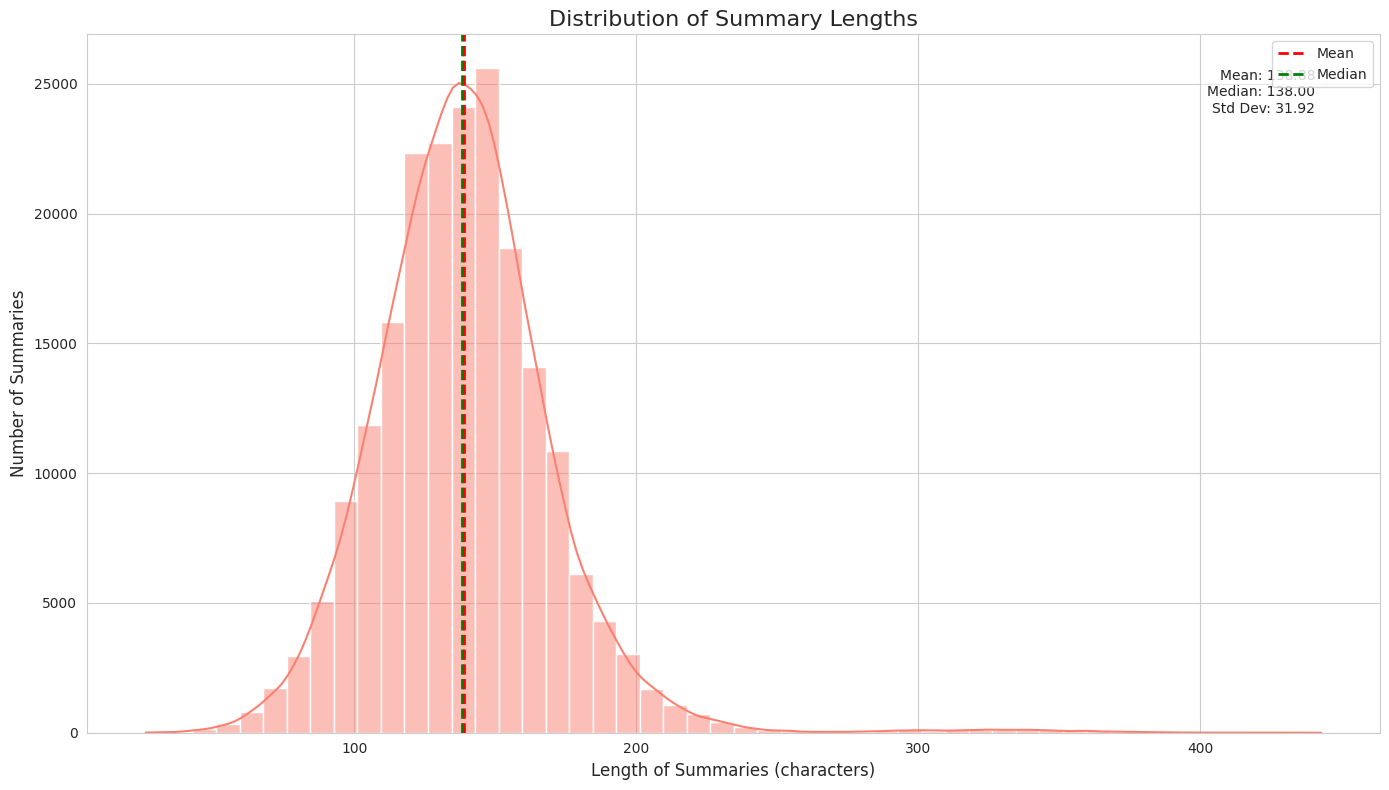

Summary length statistics:
count    204855.000000
mean        138.882898
std          31.919788
min          26.000000
25%         119.000000
50%         138.000000
75%         156.000000
max         443.000000
Name: processed_summary, dtype: float64

Skewness: 1.21
Kurtosis: 6.46
Summaries longer than 500 characters: 0 (0.00%)
Summaries shorter than 50 characters: 156 (0.08%)

Percentiles of summary lengths:
1th percentile: 72.00
5th percentile: 91.00
10th percentile: 102.00
25th percentile: 119.00
50th percentile: 138.00
75th percentile: 156.00
90th percentile: 175.00
95th percentile: 189.00
99th percentile: 224.00

Proportion of summaries at max length (443 characters): 0.00%


In [13]:
# Calculate summary lengths
summary_lengths = df['processed_summary'].str.len()

# Plot distribution of summary lengths
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")
sns.histplot(summary_lengths, bins=50, kde=True, color='salmon')
plt.axvline(summary_lengths.mean(), color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(summary_lengths.median(), color='green', linestyle='dashed', linewidth=2, label='Median')
stats = summary_lengths.describe()
plt.text(0.95, 0.95, f"Mean: {stats['mean']:.2f}\nMedian: {stats['50%']:.2f}\nStd Dev: {stats['std']:.2f}",
         transform=plt.gca().transAxes, va='top', ha='right', bbox=dict(facecolor='white', alpha=0.5))
plt.title('Distribution of Summary Lengths', fontsize=16)
plt.xlabel('Length of Summaries (characters)', fontsize=12)
plt.ylabel('Number of Summaries', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

# Print detailed statistics for summaries
print("Summary length statistics:")
print(summary_lengths.describe())
print(f"\nSkewness: {summary_lengths.skew():.2f}")
print(f"Kurtosis: {summary_lengths.kurtosis():.2f}")
print(f"Summaries longer than 500 characters: {(summary_lengths > 500).sum()} ({(summary_lengths > 500).mean()*100:.2f}%)")
print(f"Summaries shorter than 50 characters: {(summary_lengths < 50).sum()} ({(summary_lengths < 50).mean()*100:.2f}%)")

percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
percentile_values = np.percentile(summary_lengths, percentiles)
print("\nPercentiles of summary lengths:")
for p, v in zip(percentiles, percentile_values):
    print(f"{p}th percentile: {v:.2f}")

max_length = summary_lengths.max()
prop_max_length = (summary_lengths == max_length).mean()
print(f"\nProportion of summaries at max length ({max_length} characters): {prop_max_length:.2%}")

## 3e. Most Frequent Terms in Articles

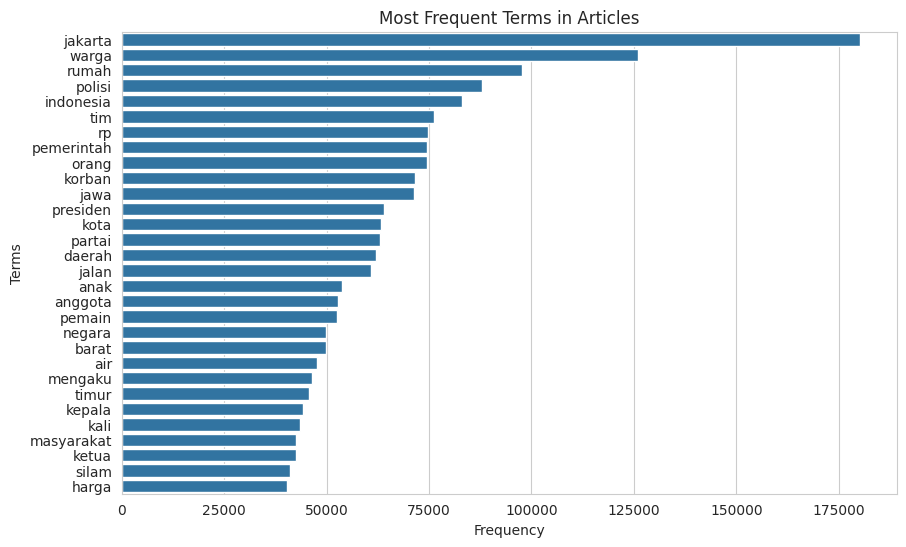

Top 30 terms in articles and their frequencies:
jakarta: 180155
warga: 126085
rumah: 97624
polisi: 88010
indonesia: 82921
tim: 76306
rp: 74659
pemerintah: 74501
orang: 74487
korban: 71662
jawa: 71219
presiden: 63980
kota: 63203
partai: 63036
daerah: 62075
jalan: 60907
anak: 53792
anggota: 52664
pemain: 52416
negara: 49909
barat: 49788
air: 47653
mengaku: 46502
timur: 45781
kepala: 44245
kali: 43611
masyarakat: 42436
ketua: 42411
silam: 40951
harga: 40416

Word count statistics for processed articles:
count    204855.000000
mean        116.741939
std          70.909872
min           4.000000
25%          74.000000
50%          98.000000
75%         138.000000
max        3825.000000
Name: processed_article, dtype: float64

Total unique words in processed articles: 269388


In [14]:
def plot_most_frequent_terms(text_series, title, n=30):
    all_words = ' '.join(text_series).split()
    freq_dist = Counter(all_words)
    common_words = freq_dist.most_common(n)

    words = [word[0] for word in common_words]
    counts = [word[1] for word in common_words]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=counts, y=words)
    plt.title(f'Most Frequent Terms in {title}')
    plt.xlabel('Frequency')
    plt.ylabel('Terms')
    plt.show()

# Most frequent terms in articles
plot_most_frequent_terms(df['processed_article'].dropna(), 'Articles')

# Print the top 30 terms and their frequencies for articles
print("Top 30 terms in articles and their frequencies:")
for word, count in Counter(' '.join(df['processed_article'].dropna()).split()).most_common(30):
    print(f"{word}: {count}")

# Calculate some statistics for articles
word_counts_article = df['processed_article'].apply(lambda x: len(x.split()))

print("\nWord count statistics for processed articles:")
print(word_counts_article.describe())

print(f"\nTotal unique words in processed articles: {len(set(' '.join(df['processed_article']).split()))}")


## 3f. Most Frequent Terms in Summaries

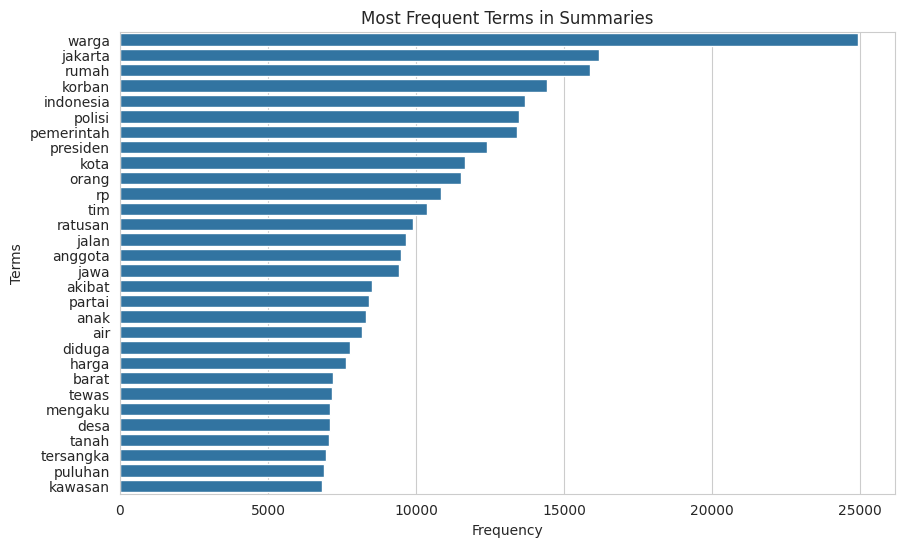

Top 30 terms in summaries and their frequencies:
warga: 24924
jakarta: 16185
rumah: 15867
korban: 14432
indonesia: 13673
polisi: 13484
pemerintah: 13411
presiden: 12393
kota: 11667
orang: 11534
rp: 10830
tim: 10381
ratusan: 9903
jalan: 9677
anggota: 9507
jawa: 9427
akibat: 8499
partai: 8419
anak: 8304
air: 8167
diduga: 7785
harga: 7625
barat: 7204
tewas: 7151
mengaku: 7106
desa: 7088
tanah: 7065
tersangka: 6950
puluhan: 6905
kawasan: 6841

Word count statistics for processed summaries:
count    204855.000000
mean         18.496947
std           4.488100
min           4.000000
25%          16.000000
50%          18.000000
75%          21.000000
max          61.000000
Name: processed_summary, dtype: float64

Total unique words in processed summaries: 93090


In [15]:
# Most frequent terms in summaries
plot_most_frequent_terms(df['processed_summary'].dropna(), 'Summaries')

# Print the top 30 terms and their frequencies for summaries
print("Top 30 terms in summaries and their frequencies:")
for word, count in Counter(' '.join(df['processed_summary'].dropna()).split()).most_common(30):
    print(f"{word}: {count}")

# Calculate some statistics for summaries
word_counts_article = df['processed_summary'].apply(lambda x: len(x.split()))

print("\nWord count statistics for processed summaries:")
print(word_counts_article.describe())

print(f"\nTotal unique words in processed summaries: {len(set(' '.join(df['processed_summary']).split()))}")


## 3g. Scatter Plot: Article vs Summary Length

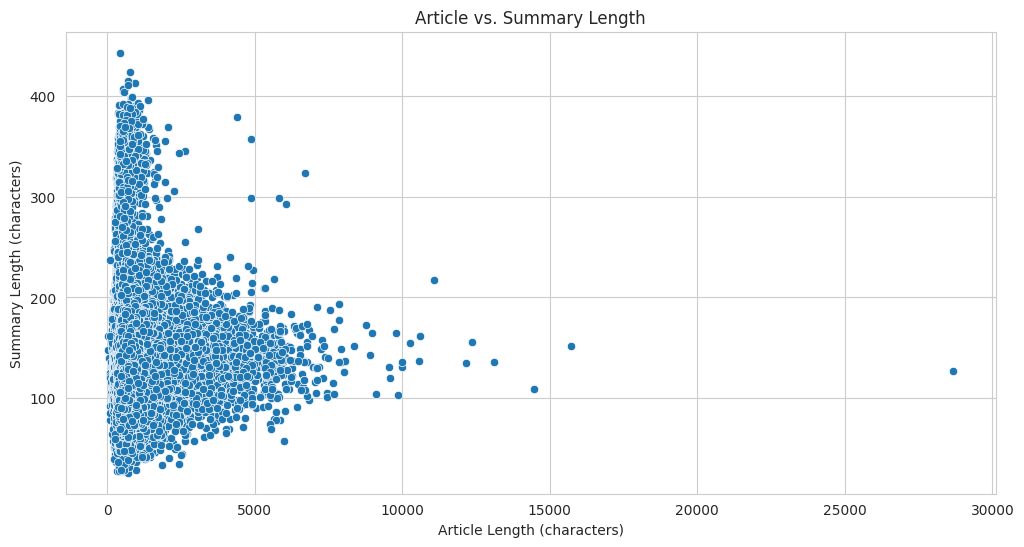

Correlation coefficient between article and summary length: 0.13
Average compression ratio (summary length / article length): 0.19


In [16]:
# Calculate the length of each processed article and summary
df['article_length'] = df['processed_article'].str.len()
df['summary_length'] = df['processed_summary'].str.len()

# Scatter plot for Article vs. Summary Length
plt.figure(figsize=(12, 6))
sns.scatterplot(x='article_length', y='summary_length', data=df)
plt.title('Article vs. Summary Length')
plt.xlabel('Article Length (characters)')
plt.ylabel('Summary Length (characters)')
plt.show()

# Calculate and print correlation coefficient
correlation = df['article_length'].corr(df['summary_length'])
print(f"Correlation coefficient between article and summary length: {correlation:.2f}")

# Calculate and print average compression ratio
df['compression_ratio'] = df['summary_length'] / df['article_length']
average_compression_ratio = df['compression_ratio'].mean()
print(f"Average compression ratio (summary length / article length): {average_compression_ratio:.2f}")


## 3h. Box Plot for Distribution of Text Lengths

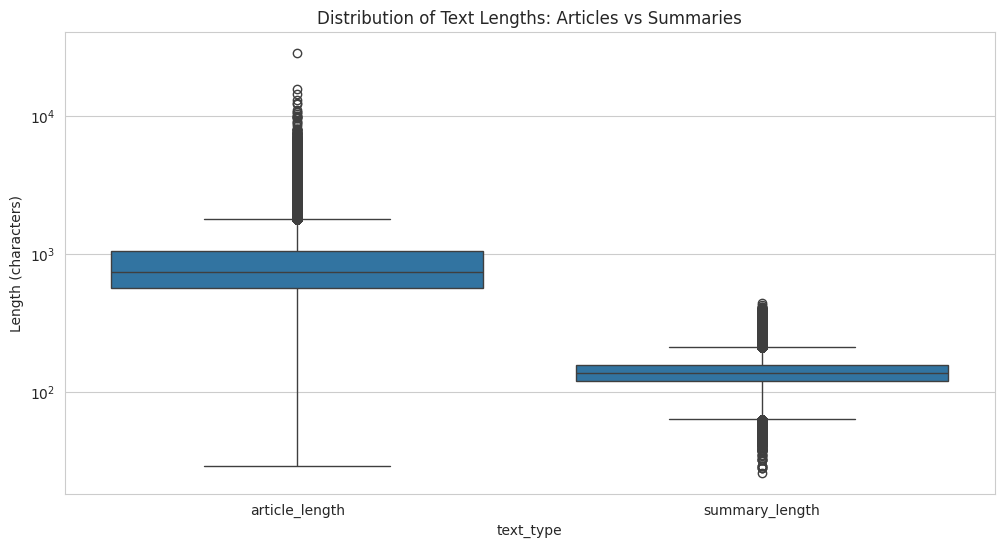


Article length statistics:
count    204855.000000
mean        885.243382
std         534.739417
min          29.000000
25%         562.000000
50%         744.000000
75%        1048.000000
max       28678.000000
Name: article_length, dtype: float64

Summary length statistics:
count    204855.000000
mean        138.882898
std          31.919788
min          26.000000
25%         119.000000
50%         138.000000
75%         156.000000
max         443.000000
Name: summary_length, dtype: float64


In [17]:
# Create a long-form dataframe for seaborn
df_long = pd.melt(df[['article_length', 'summary_length']],
                  var_name='text_type',
                  value_name='length')

# Create box plots
plt.figure(figsize=(12, 6))
sns.boxplot(x='text_type', y='length', data=df_long)
plt.title('Distribution of Text Lengths: Articles vs Summaries')
plt.ylabel('Length (characters)')
plt.yscale('log')  # Use log scale for better visualization
plt.show()

# Print summary statistics
print("\nArticle length statistics:")
print(df['article_length'].describe())
print("\nSummary length statistics:")
print(df['summary_length'].describe())

## 3i. Plotting Bi-grams in Articles

In [18]:
def plot_ngrams(text_series, ngram_range, n=20, title="Top N-grams"):
    count_vect = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(text_series)
    ngrams = count_vect.transform(text_series)
    sum_ngrams = ngrams.sum(axis=0)
    ngram_freq = [(ngram, sum_ngrams[0, idx]) for ngram, idx in count_vect.vocabulary_.items()]
    ngram_freq = sorted(ngram_freq, key=lambda x: x[1], reverse=True)[:n]

    df_ngrams = pd.DataFrame(ngram_freq, columns=['ngram', 'frequency'])

    plt.figure(figsize=(14, 8))
    sns.barplot(x='frequency', y='ngram', data=df_ngrams)
    plt.title(title)
    plt.xlabel('Frequency')
    plt.tight_layout()
    plt.show()

# Print the top n-grams and their frequencies
    print(f"\nTop {n} {title}:")
    for ngram, freq in ngram_freq:
        print(f"{ngram}: {freq}")

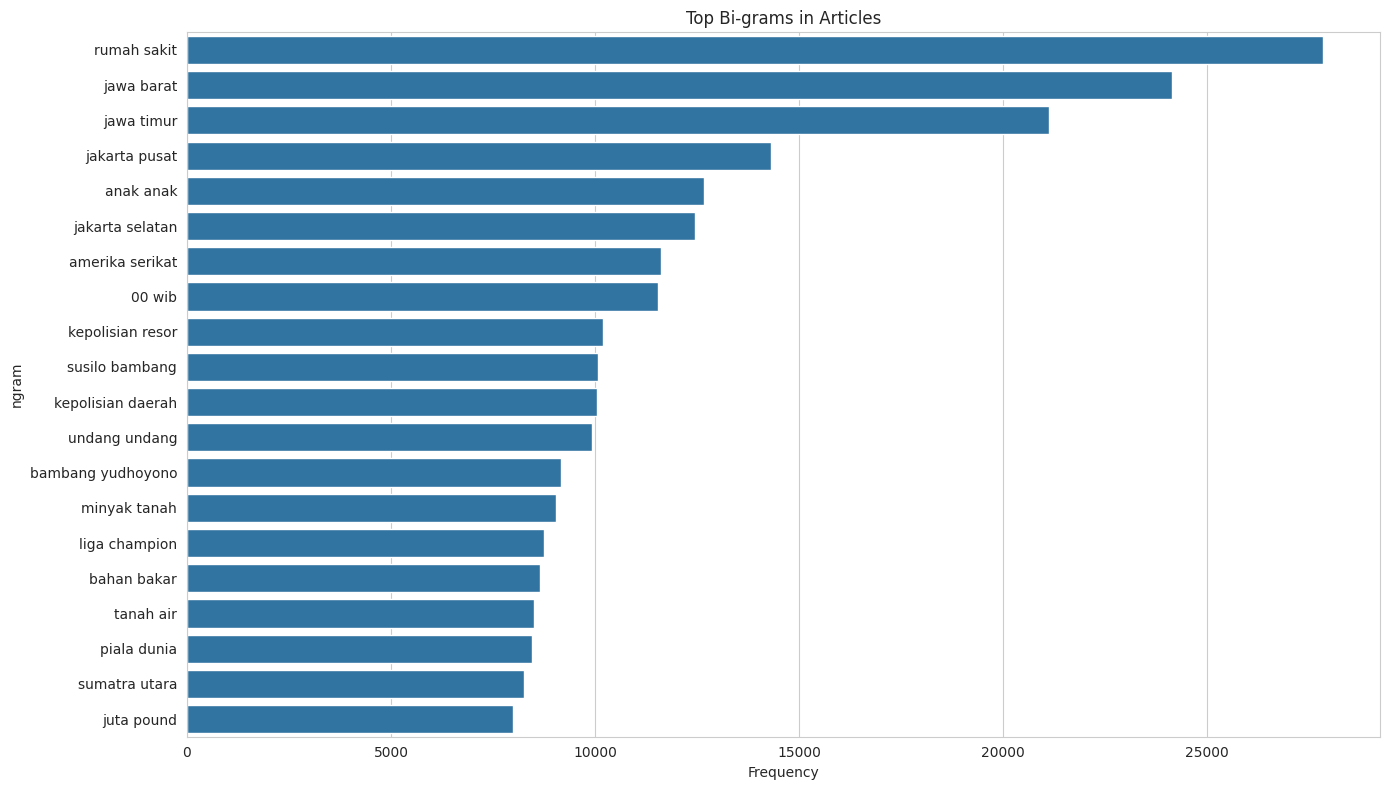


Top 20 Top Bi-grams in Articles:
rumah sakit: 27845
jawa barat: 24138
jawa timur: 21115
jakarta pusat: 14320
anak anak: 12666
jakarta selatan: 12452
amerika serikat: 11620
00 wib: 11538
kepolisian resor: 10185
susilo bambang: 10071
kepolisian daerah: 10053
undang undang: 9920
bambang yudhoyono: 9159
minyak tanah: 9056
liga champion: 8760
bahan bakar: 8650
tanah air: 8506
piala dunia: 8445
sumatra utara: 8249
juta pound: 7979


In [19]:
# Plotting bi-grams in articles
plot_ngrams(df['processed_article'].dropna(), (2,2), title="Top Bi-grams in Articles")

##  3j. Plotting Bi-grams in Summaries

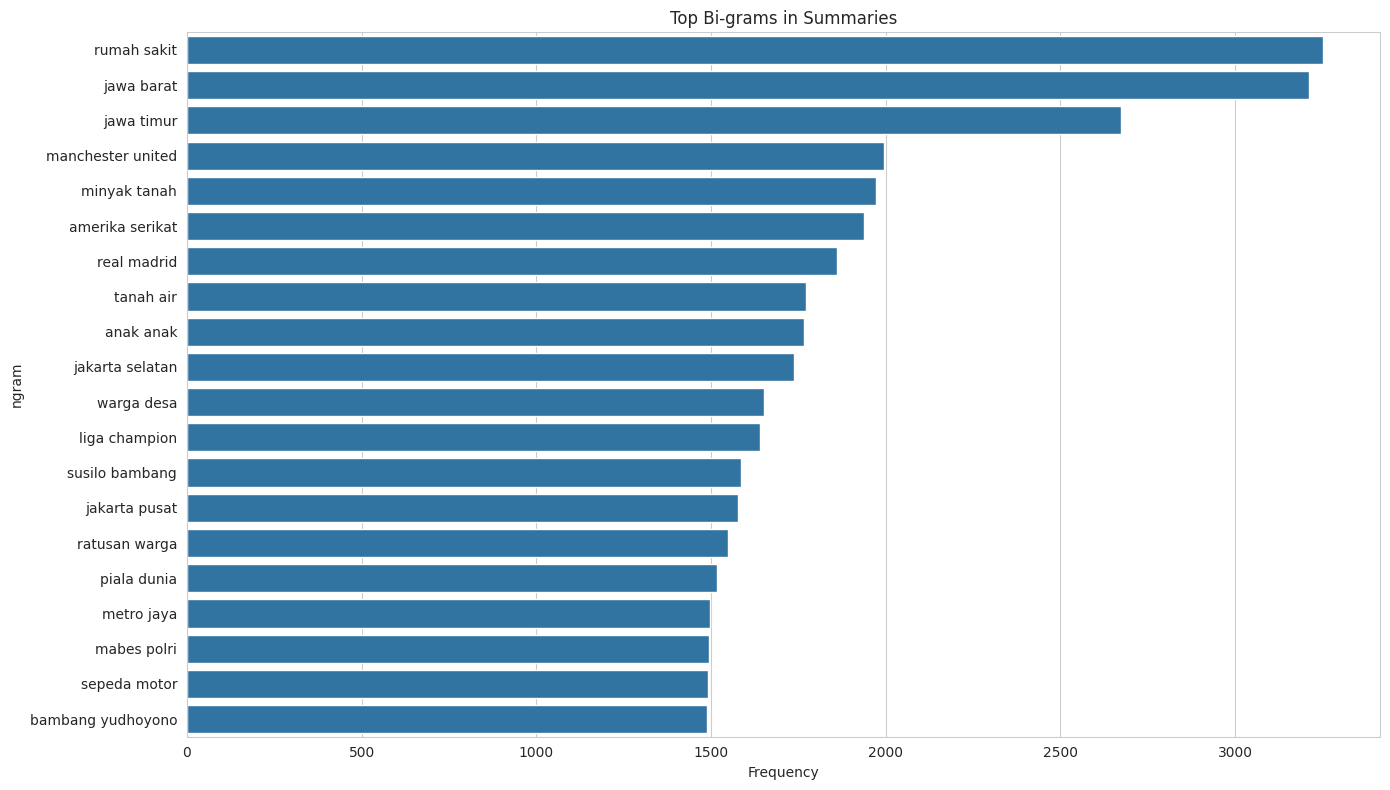


Top 20 Top Bi-grams in Summaries:
rumah sakit: 3252
jawa barat: 3211
jawa timur: 2672
manchester united: 1995
minyak tanah: 1972
amerika serikat: 1939
real madrid: 1860
tanah air: 1772
anak anak: 1766
jakarta selatan: 1737
warga desa: 1651
liga champion: 1641
susilo bambang: 1585
jakarta pusat: 1578
ratusan warga: 1548
piala dunia: 1517
metro jaya: 1497
mabes polri: 1493
sepeda motor: 1492
bambang yudhoyono: 1488


In [20]:
# Plotting bi-grams in summaries
plot_ngrams(df['processed_summary'].dropna(), (2,2), title="Top Bi-grams in Summaries")

## 3k. Plotting Tri-grams in Articles

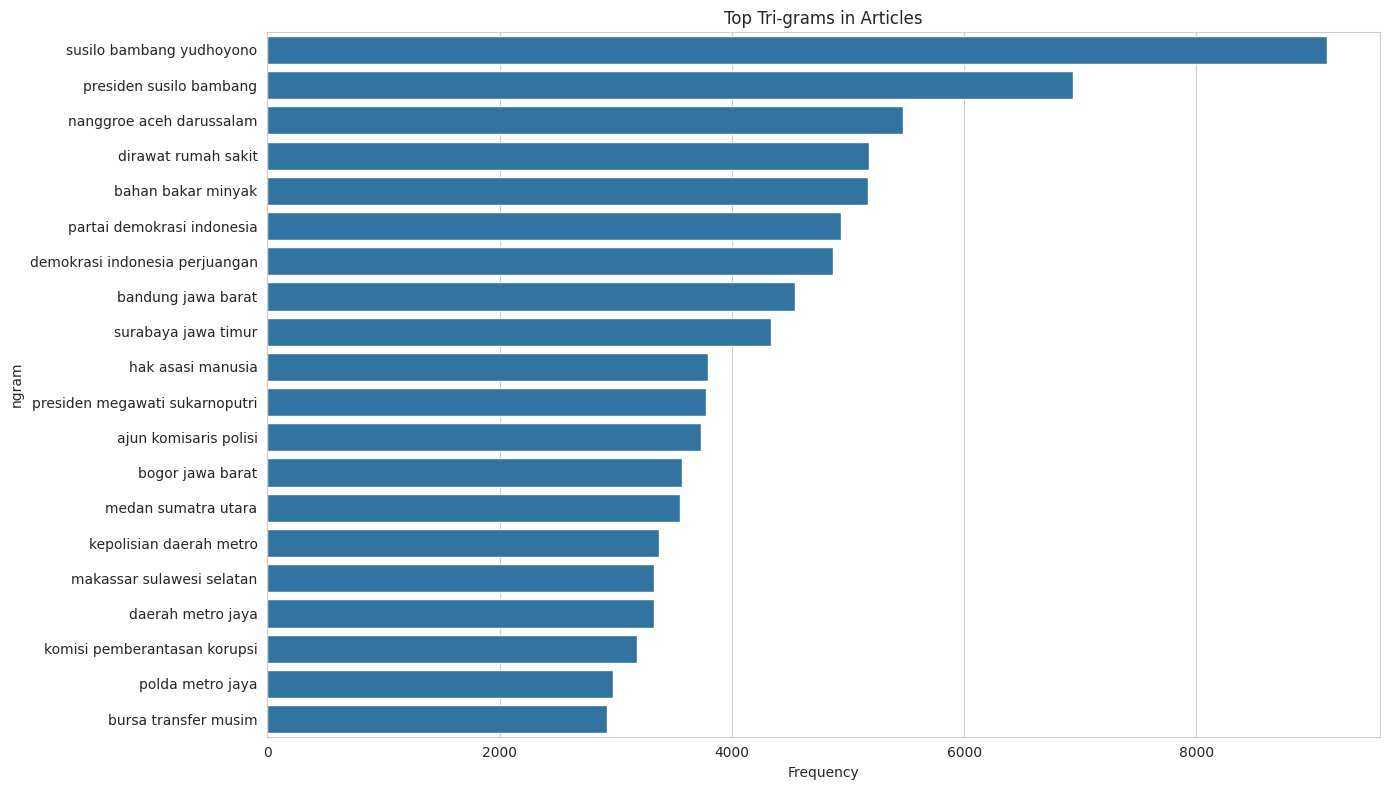


Top 20 Top Tri-grams in Articles:
susilo bambang yudhoyono: 9125
presiden susilo bambang: 6934
nanggroe aceh darussalam: 5475
dirawat rumah sakit: 5184
bahan bakar minyak: 5175
partai demokrasi indonesia: 4939
demokrasi indonesia perjuangan: 4870
bandung jawa barat: 4544
surabaya jawa timur: 4336
hak asasi manusia: 3796
presiden megawati sukarnoputri: 3774
ajun komisaris polisi: 3732
bogor jawa barat: 3574
medan sumatra utara: 3554
kepolisian daerah metro: 3374
makassar sulawesi selatan: 3331
daerah metro jaya: 3331
komisi pemberantasan korupsi: 3186
polda metro jaya: 2977
bursa transfer musim: 2925


In [21]:
# Plotting tri-grams in articles
plot_ngrams(df['processed_article'].dropna(), (3,3), title="Top Tri-grams in Articles")

## 3l. Plotting Tri-grams in Summaries

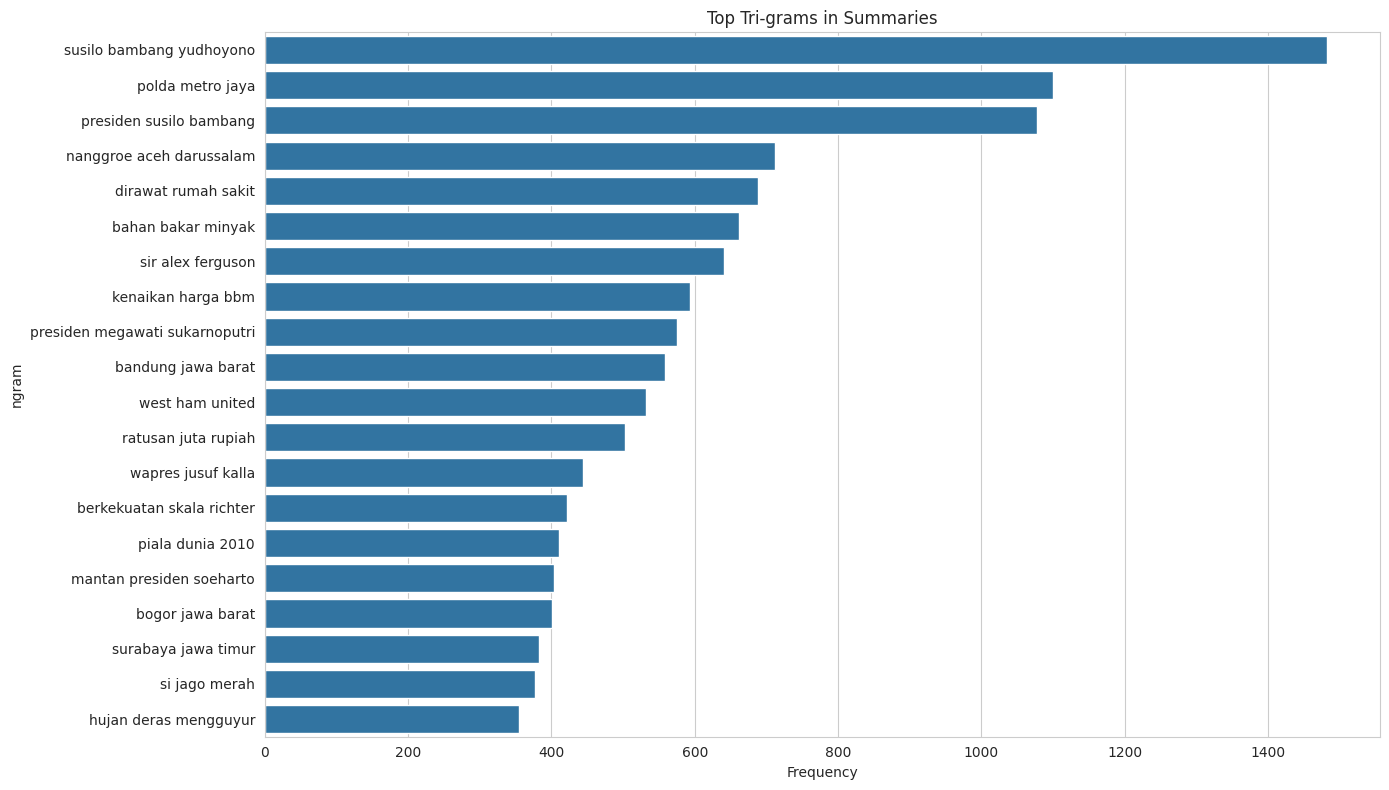


Top 20 Top Tri-grams in Summaries:
susilo bambang yudhoyono: 1482
polda metro jaya: 1100
presiden susilo bambang: 1078
nanggroe aceh darussalam: 712
dirawat rumah sakit: 688
bahan bakar minyak: 661
sir alex ferguson: 641
kenaikan harga bbm: 594
presiden megawati sukarnoputri: 575
bandung jawa barat: 559
west ham united: 532
ratusan juta rupiah: 503
wapres jusuf kalla: 444
berkekuatan skala richter: 422
piala dunia 2010: 411
mantan presiden soeharto: 404
bogor jawa barat: 401
surabaya jawa timur: 382
si jago merah: 377
hujan deras mengguyur: 355


In [22]:
# Plotting tri-grams in summaries
plot_ngrams(df['processed_summary'].dropna(), (3,3), title="Top Tri-grams in Summaries")

## 3m. Sentiment Analysis for Articles

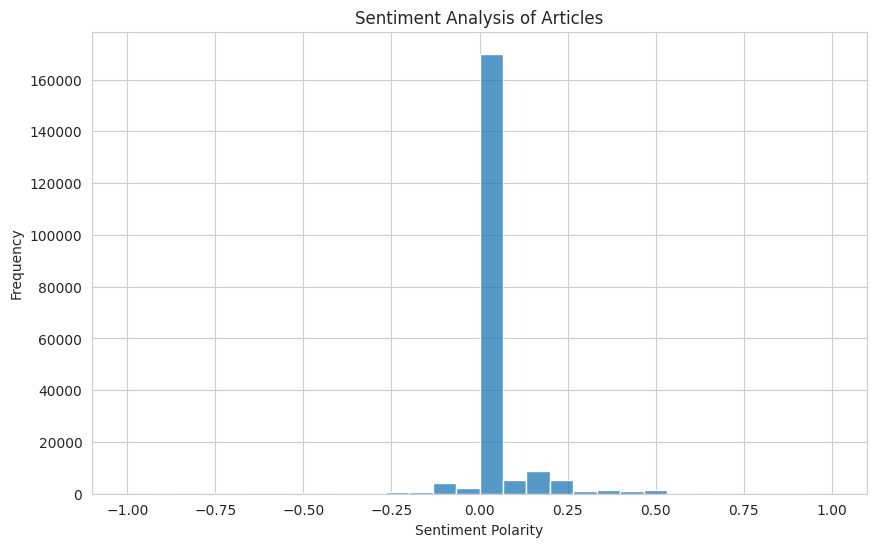


Sentiment Score Statistics for Sentiment Analysis of Articles:
count    204855.000000
mean          0.022460
std           0.115233
min          -1.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: processed_article, dtype: float64

Positive sentiment: 14.07%
Negative sentiment: 4.47%
Neutral sentiment: 81.46%


In [23]:
def plot_sentiment(text_series, title="Sentiment Analysis"):
    sentiment_scores = text_series.apply(lambda x: TextBlob(x).sentiment.polarity)

    plt.figure(figsize=(10, 6))
    sns.histplot(sentiment_scores, kde=False, bins=30)
    plt.title(title)
    plt.xlabel('Sentiment Polarity')
    plt.ylabel('Frequency')
    plt.show()

    print(f"\nSentiment Score Statistics for {title}:")
    print(sentiment_scores.describe())

    positive = (sentiment_scores > 0).mean() * 100
    negative = (sentiment_scores < 0).mean() * 100
    neutral = (sentiment_scores == 0).mean() * 100
    print(f"\nPositive sentiment: {positive:.2f}%")
    print(f"Negative sentiment: {negative:.2f}%")
    print(f"Neutral sentiment: {neutral:.2f}%")

# Sentiment analysis for articles
plot_sentiment(df['processed_article'].dropna(), "Sentiment Analysis of Articles")

## 3n. Sentiment Analysis for Summaries

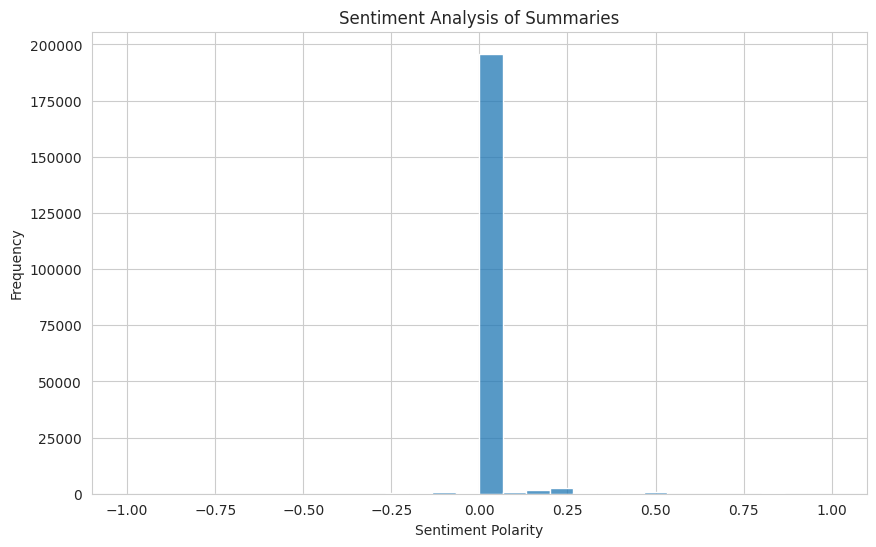


Sentiment Score Statistics for Sentiment Analysis of Summaries:
count    204855.000000
mean          0.007038
std           0.063332
min          -1.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: processed_summary, dtype: float64

Positive sentiment: 3.57%
Negative sentiment: 0.91%
Neutral sentiment: 95.52%


In [24]:
# Sentiment analysis for summaries
plot_sentiment(df['processed_summary'].dropna(), "Sentiment Analysis of Summaries")

## 3o. Top Words in Topics

In [11]:
# Topic Modeling
# Vectorize the text
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(df['processed_article'])

# Fit LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(doc_term_matrix)

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")

# Display the top words in the topics
print("\nTop words in LDA topics:")
print_top_words(lda, vectorizer.get_feature_names_out(), 10)

# Compression Ratio
compression_ratio = df['processed_summary'].str.split().str.len().mean() / df['processed_article'].str.split().str.len().mean()
print(f"\nCompression ratio: {compression_ratio:.2f}")


Top words in LDA topics:
Topic 1: jakarta, presiden, indonesia, ketua, negara, partai, anggota, pemerintah, menteri, aceh
Topic 2: warga, air, banjir, rumah, jalan, desa, jawa, kabupaten, suara, korban
Topic 3: rp, jakarta, harga, anak, pemerintah, minyak, indonesia, ribu, persen, pasar
Topic 4: pemain, tim, pertandingan, musim, gol, klub, menit, liga, bermain, babak
Topic 5: polisi, korban, rumah, warga, kepolisian, jakarta, tersangka, kota, jawa, orang

Compression ratio: 0.16


# 4. Data Preprocessing

## 4a. Splitting the Dataset

In [12]:
# Split the 'train' dataset into a new 'train' and 'validation' dataset
dataset = dataset['train'].train_test_split(test_size=0.2)

train_dataset = dataset['train']
val_dataset = dataset['test']
trust_remote_code=True

## 4b. Loading the Tokenizer from a Pretrained Model

In [18]:
# 4b. Loading the Tokenizer from a Pretrained Model
tokenizer = BertTokenizer.from_pretrained("cahya/bert-base-indonesian-1.5G")

# Set the beginning-of-sequence token to the [CLS] token
tokenizer.bos_token = tokenizer.cls_token

# Set the end-of-sequence token to the [SEP] token
tokenizer.eos_token = tokenizer.sep_token

# Optional: Print tokenizer information
print(f"Vocabulary size: {len(tokenizer)}")
print(f"BOS token: {tokenizer.bos_token}")
print(f"EOS token: {tokenizer.eos_token}")

Vocabulary size: 32000
BOS token: [CLS]
EOS token: [SEP]


## 4c. Defining the Maximum Length of the Input and Target Sequences

In [19]:
# 4c. Defining the Maximum Length of the Input and Target Sequences
max_input_length = 256
max_target_length = 256

# Optional: Print the defined lengths
print(f"Maximum input sequence length: {max_input_length}")
print(f"Maximum target sequence length: {max_target_length}")

Maximum input sequence length: 256
Maximum target sequence length: 256


## 4d. Tokenizing and Encoding Articles and Summaries

In [20]:
# Adjust the preprocessing function based on the actual column names
def preprocess_function(examples):
    # Use the correct column names here
    articles = examples['clean_article']  # or the correct column name for articles
    summaries = examples['clean_summary']  # or the correct column name for summaries

    inputs = tokenizer(articles, max_length=max_input_length, padding='max_length', truncation=True)
    targets = tokenizer(summaries, max_length=max_target_length, padding='max_length', truncation=True)

    inputs['labels'] = targets['input_ids']
    inputs['decoder_input_ids'] = [[tokenizer.bos_token_id] + target[:-1] for target in targets['input_ids']]

    return inputs

## 4e. Mapping Train and Validation Dataset

In [21]:
# Apply preprocessing to the datasets
train_dataset = train_dataset.map(preprocess_function, batched=True, remove_columns=train_dataset.column_names)
val_dataset = val_dataset.map(preprocess_function, batched=True, remove_columns=val_dataset.column_names)

print(f"Processed training dataset size: {len(train_dataset)}")
print(f"Processed validation dataset size: {len(val_dataset)}")
print(f"Features in processed datasets: {train_dataset.features}")

print("\nSample from processed training dataset:")
print(train_dataset[0])

Map:   0%|          | 0/155106 [00:00<?, ? examples/s]

Map:   0%|          | 0/38777 [00:00<?, ? examples/s]

Processed training dataset size: 155106
Processed validation dataset size: 38777
Features in processed datasets: {'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'decoder_input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}

Sample from processed training dataset:
{'input_ids': [3, 17715, 1050, 17, 3036, 15, 2647, 29, 2357, 6165, 4109, 31929, 15464, 4121, 14140, 1533, 8445, 4653, 1637, 24544, 4653, 12168, 1888, 2726, 11956, 17, 7472, 4109, 1542, 6729, 1708, 3654, 2607, 19042, 1509, 15805, 8635, 17, 3290, 5668, 2788, 13395, 2605, 15, 2552, 15, 1509, 4275, 12328, 1635, 15, 8126, 7463, 6262, 1495, 3564, 13843, 15, 2647, 15, 11553, 11, 2162, 18, 24, 12, 17, 12328, 6553, 15, 7472, 41

## 4f. Print Processed Examples from the Training Dataset

In [22]:
# 4f. Print Processed Examples from the Training Dataset
print("Processed Examples from the Training Dataset:")
for i in range(3):
    print(f"Example {i+1}:")
    print("input_ids:", train_dataset[i]['input_ids'][:50], "...")  # Truncated for readability
    print("attention_mask:", train_dataset[i]['attention_mask'][:50], "...")
    print("labels:", train_dataset[i]['labels'][:50], "...")
    print("decoder_input_ids:", train_dataset[i]['decoder_input_ids'][:50], "...")
    print("\n")

Processed Examples from the Training Dataset:
Example 1:
input_ids: [3, 17715, 1050, 17, 3036, 15, 2647, 29, 2357, 6165, 4109, 31929, 15464, 4121, 14140, 1533, 8445, 4653, 1637, 24544, 4653, 12168, 1888, 2726, 11956, 17, 7472, 4109, 1542, 6729, 1708, 3654, 2607, 19042, 1509, 15805, 8635, 17, 3290, 5668, 2788, 13395, 2605, 15, 2552, 15, 1509, 4275, 12328, 1635] ...
attention_mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] ...
labels: [3, 1504, 4898, 1919, 7967, 18362, 12328, 1635, 2793, 4109, 8445, 4653, 8635, 8203, 1637, 24544, 4653, 1572, 3654, 19042, 1509, 15805, 8635, 17, 7472, 4109, 1542, 2165, 4684, 12593, 2424, 17, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2] ...
decoder_input_ids: [3, 3, 1504, 4898, 1919, 7967, 18362, 12328, 1635, 2793, 4109, 8445, 4653, 8635, 8203, 1637, 24544, 4653, 1572, 3654, 19042, 1509, 15805, 8635, 17, 7472, 4109, 1542, 2165, 4684, 12593, 

## 4g. Print Processed Examples from Validation Dataset

In [23]:
# 4g. Print Processed Examples from Validation Dataset
print("Processed Examples from the Validation Dataset:")
for i in range(3):
    print(f"Example {i+1}:")
    print("input_ids:", val_dataset[i]['input_ids'][:50], "...")  # Truncated for readability
    print("attention_mask:", val_dataset[i]['attention_mask'][:50], "...")
    print("labels:", val_dataset[i]['labels'][:50], "...")
    print("decoder_input_ids:", val_dataset[i]['decoder_input_ids'][:50], "...")
    print("\n")

Processed Examples from the Validation Dataset:
Example 1:
input_ids: [3, 17715, 1050, 17, 3036, 15, 2647, 29, 2882, 6124, 4107, 1657, 10896, 5255, 4968, 2895, 3525, 1028, 16, 9298, 4958, 2148, 1994, 1542, 11, 3066, 18, 23, 12, 15, 5036, 1555, 17630, 2642, 17, 1855, 4564, 2487, 7051, 8431, 15773, 5076, 23, 17, 4359, 17, 10896, 4958, 2403, 1994] ...
attention_mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] ...
labels: [3, 3167, 4968, 2895, 3525, 1028, 15, 2647, 2207, 1509, 9298, 15, 2326, 2070, 15, 3244, 1786, 3354, 3947, 1572, 4764, 10026, 17, 3521, 2882, 2935, 6612, 2882, 2931, 1520, 16, 2419, 5255, 4968, 2895, 3525, 1028, 16, 9298, 17, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2] ...
decoder_input_ids: [3, 3, 3167, 4968, 2895, 3525, 1028, 15, 2647, 2207, 1509, 9298, 15, 2326, 2070, 15, 3244, 1786, 3354, 3947, 1572, 4764, 10026, 17, 3521, 2882, 2935, 6612, 2882, 2931, 1520, 16, 2419, 5255, 49

## 4h. Print The Length of Training and Validation Dataset

In [24]:
# 4h. Print The Length of Training and Validation Dataset
print(f"Length of Training Dataset: {len(train_dataset)}")
print(f"Length of Validation Dataset: {len(val_dataset)}")

Length of Training Dataset: 155106
Length of Validation Dataset: 38777


## 4i. Print The First Element of Training and Validation Dataset

In [25]:
# 4i. Print The First Element of Training and Validation Dataset
print("\nFirst Element of Training Dataset:")
for key, value in train_dataset[0].items():
    print(f"{key}: {value[:50]}...")  # Truncated for readability

print("\nFirst Element of Validation Dataset:")
for key, value in val_dataset[0].items():
    print(f"{key}: {value[:50]}...")  # Truncated for readability


First Element of Training Dataset:
input_ids: [3, 17715, 1050, 17, 3036, 15, 2647, 29, 2357, 6165, 4109, 31929, 15464, 4121, 14140, 1533, 8445, 4653, 1637, 24544, 4653, 12168, 1888, 2726, 11956, 17, 7472, 4109, 1542, 6729, 1708, 3654, 2607, 19042, 1509, 15805, 8635, 17, 3290, 5668, 2788, 13395, 2605, 15, 2552, 15, 1509, 4275, 12328, 1635]...
token_type_ids: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]...
attention_mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]...
labels: [3, 1504, 4898, 1919, 7967, 18362, 12328, 1635, 2793, 4109, 8445, 4653, 8635, 8203, 1637, 24544, 4653, 1572, 3654, 19042, 1509, 15805, 8635, 17, 7472, 4109, 1542, 2165, 4684, 12593, 2424, 17, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]...
decoder_input_ids: [3, 3, 1504, 4898, 1919, 7967, 18362, 1

# 5. Load Pre-trained Model

## 5a. Load Pre-trained BERT Model

In [26]:
# 5a. Load Pre-trained BERT Model
bert_model = BertModel.from_pretrained("cahya/bert-base-indonesian-1.5G")

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

In [27]:
# Print model information
print("BERT model loaded:")
print(f"Vocabulary size: {bert_model.config.vocab_size}")
print(f"Hidden size: {bert_model.config.hidden_size}")
print(f"Number of hidden layers: {bert_model.config.num_hidden_layers}")
print(f"Number of attention heads: {bert_model.config.num_attention_heads}")

BERT model loaded:
Vocabulary size: 32000
Hidden size: 768
Number of hidden layers: 12
Number of attention heads: 12


## 5b. Load Pre-trained GPT-2 Model

In [28]:
# 5b. Load Pre-trained GPT-2 Model Configuration
gpt2_config = GPT2Config.from_pretrained("cahya/gpt2-small-indonesian-522M", add_cross_attention=True)

config.json:   0%|          | 0.00/573 [00:00<?, ?B/s]

In [29]:
# Print model information
print("\nGPT-2 configuration loaded:")
print(f"Vocabulary size: {gpt2_config.vocab_size}")
print(f"Hidden size: {gpt2_config.hidden_size}")
print(f"Number of hidden layers: {gpt2_config.num_hidden_layers}")
print(f"Number of attention heads: {gpt2_config.num_attention_heads}")
print(f"Cross-attention enabled: {gpt2_config.add_cross_attention}")


GPT-2 configuration loaded:
Vocabulary size: 50257
Hidden size: 768
Number of hidden layers: 12
Number of attention heads: 12
Cross-attention enabled: True


# Create Model

In [30]:
# Create the GPT-2 model with the modified configuration
gpt2_model = GPT2LMHeadModel(gpt2_config)

In [31]:
# Combine BERT and GPT-2 into an Encoder-Decoder model
model = EncoderDecoderModel(encoder=bert_model, decoder=gpt2_model)

In [32]:
# Update special tokens based on the tokenizer
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.eos_token_id = tokenizer.sep_token_id

In [33]:
# Check if a GPU is available
if torch.cuda.is_available():
    print("GPU is available")
    device = torch.device("cuda")
else:
    print("GPU is not available, using CPU instead")
    device = torch.device("cpu")

GPU is available


In [34]:
# Move the model to the appropriate device
model = model.to(device)

# Print model architecture
print(model)

# Print model parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

# Print trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")

EncoderDecoderModel(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

# Training Model

## 6a. Initial Training

In [35]:
# Define the optimized training arguments
optimized_training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='/content/drive/MyDrive/logs',
    logging_steps=100,
    save_steps=1000,
    eval_steps=1000,
    evaluation_strategy="steps",
    fp16=True,
    fp16_opt_level="O2",
    gradient_accumulation_steps=4,
    learning_rate=5e-5,
    max_grad_norm=1.0,
    dataloader_num_workers=2,
    disable_tqdm=False,  # Enable progress bars for visibility
    report_to="none",  # Disable wandb logging
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [36]:
# Create the optimized trainer
optimized_trainer = Trainer(
    model=model,
    args=optimized_training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Enable gradient checkpointing to save memory
model.gradient_checkpointing_enable()


In [37]:
# Train the model
print("Starting optimized training...")
optimized_trainer.train()
print("Optimized training completed.")

# Save the model
model_save_path = "/content/drive/MyDrive/saved_model"
optimized_trainer.save_model(model_save_path)
print(f"Model saved to {model_save_path}")

Starting optimized training...


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:643: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Step,Training Loss,Validation Loss
1000,0.791200,0.751249
2000,0.497800,0.474063
3000,0.405900,0.390578
4000,0.357400,0.348694
5000,0.320900,0.323474
6000,0.303400,0.309046
7000,0.294800,0.301842


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:643: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:643: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no 

Optimized training completed.
Model saved to /content/drive/MyDrive/saved_model


## 6b. Continue Training

In [38]:
# Define the path to the checkpoint we want to continue from
model_path = "/content/drive/MyDrive/saved_model"  # Assuming we want to continue from saved_model

# Load the model and tokenizer
model = EncoderDecoderModel.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained("cahya/bert2gpt-indonesian-summarization")

tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/230k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.26k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [39]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

EncoderDecoderModel(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [42]:
# Define the optimized training arguments for continued training
continued_training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/results_continued",
    num_train_epochs=2,  # Adjust as needed
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='/content/drive/MyDrive/logs_continued',
    logging_steps=100,
    save_steps=1000,
    eval_steps=1000,
    evaluation_strategy="steps",
    fp16=True,
    fp16_opt_level="O2",
    gradient_accumulation_steps=4,
    learning_rate=2e-5,  # Lower learning rate for fine-tuning
    max_grad_norm=1.0,
    dataloader_num_workers=2,
    disable_tqdm=False,
    report_to="none",  # Disable wandb logging
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [43]:
# Create the trainer for continued training
continued_trainer = Trainer(
    model=model,
    args=continued_training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

In [47]:
# Continue training the model
print(f"Continuing optimized training")
continued_trainer.train()
print("Continued optimized training completed.")

# Save the final model
final_model_path = "/content/drive/MyDrive/final_model"
continued_trainer.save_model(final_model_path)
print(f"Final model saved to {final_model_path}")

# Optionally, save the tokenizer alongside the model
tokenizer.save_pretrained(final_model_path)
print(f"Tokenizer saved to {final_model_path}")

Continuing optimized training


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:643: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Step,Training Loss,Validation Loss
1000,0.292400,0.298315
2000,0.276300,0.288289
3000,0.265200,0.280795
4000,0.256800,0.276793


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:643: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:643: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no 

Step,Training Loss,Validation Loss
1000,0.292400,0.298315
2000,0.276300,0.288289
3000,0.265200,0.280795
4000,0.256800,0.276793


There were missing keys in the checkpoint model loaded: ['decoder.lm_head.weight'].


Continued optimized training completed.
Final model saved to /content/drive/MyDrive/final_model
Tokenizer saved to /content/drive/MyDrive/final_model


# Evaluate Model

## 7a. Validation Loss and Training Loss

Loading trainer state...
Trainer state loaded successfully.
Processing training logs...


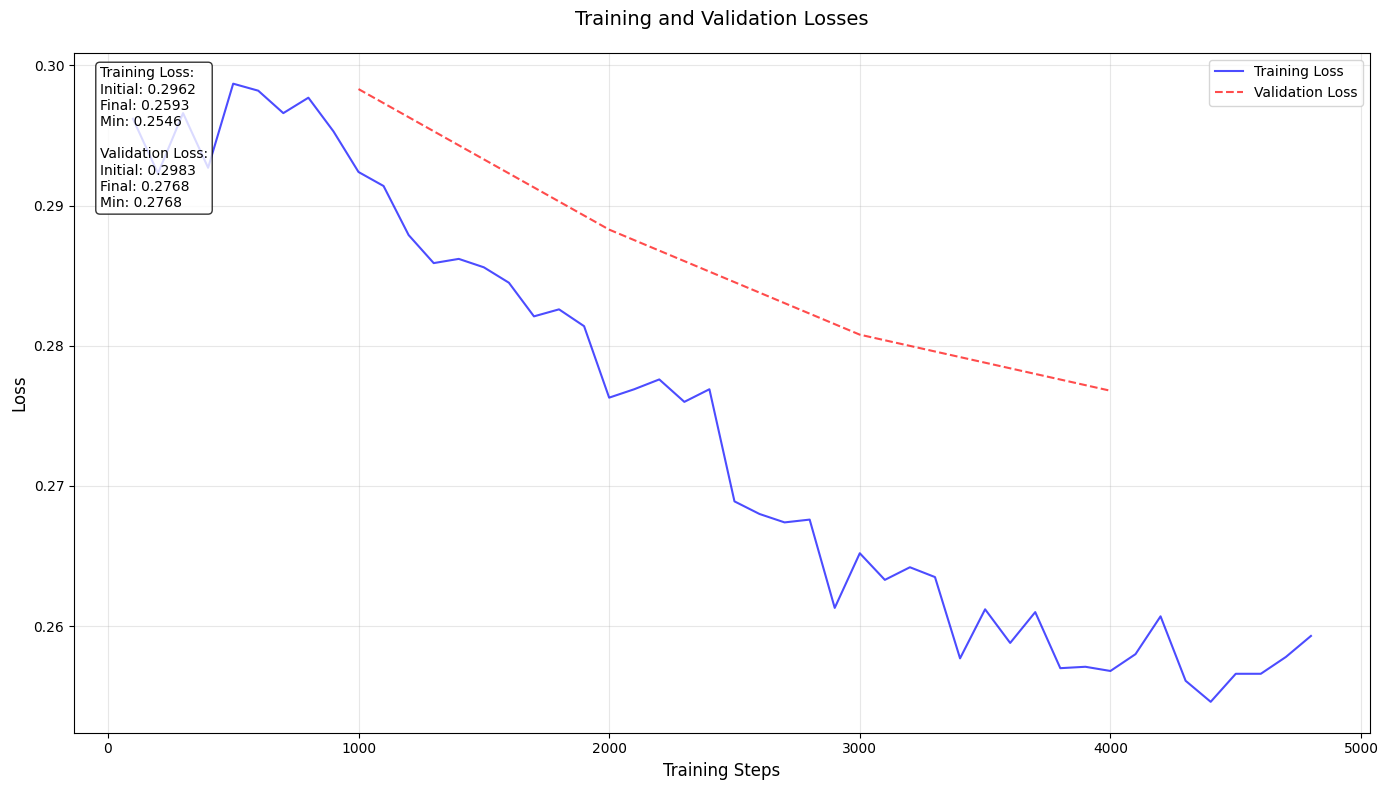


=== Training Summary ===
Total Steps: 4800
Number of Evaluations: 4

Training Loss:
Initial: 0.2962
Final: 0.2593
Minimum: 0.2546
Mean: 0.2743
Improvement: 0.0369

Validation Loss:
Initial: 0.2983
Final: 0.2768
Minimum: 0.2768
Mean: 0.2860
Improvement: 0.0215


In [55]:
# Define the path to your trainer state file
trainer_state_path = '/content/drive/MyDrive/results_continued/checkpoint-4846/trainer_state.json'

try:
    # Load and verify the trainer state
    print("Loading trainer state...")
    if not os.path.exists(trainer_state_path):
        raise FileNotFoundError(f"Trainer state file not found at: {trainer_state_path}")

    with open(trainer_state_path, 'r') as file:
        trainer_state = json.load(file)
    print("Trainer state loaded successfully.")

    # Initialize containers
    train_losses = []
    val_losses = []
    steps = []
    val_steps = []

    # Process the log history
    print("Processing training logs...")
    for log in trainer_state['log_history']:
        if 'loss' in log:
            train_losses.append(log['loss'])
            steps.append(log['step'])
        if 'eval_loss' in log:
            val_losses.append(log['eval_loss'])
            val_steps.append(log['step'])

    # Calculate statistics
    stats = {
        'train_initial': train_losses[0] if train_losses else None,
        'train_final': train_losses[-1] if train_losses else None,
        'train_min': min(train_losses) if train_losses else None,
        'train_max': max(train_losses) if train_losses else None,
        'train_mean': np.mean(train_losses) if train_losses else None,
        'val_initial': val_losses[0] if val_losses else None,
        'val_final': val_losses[-1] if val_losses else None,
        'val_min': min(val_losses) if val_losses else None,
        'val_max': max(val_losses) if val_losses else None,
        'val_mean': np.mean(val_losses) if val_losses else None,
    }

    # Create the visualization
    plt.figure(figsize=(14, 8))

    # Plot training loss
    plt.plot(steps, train_losses, label='Training Loss', color='blue', alpha=0.7)

    # Plot validation loss
    plt.plot(val_steps, val_losses, label='Validation Loss', color='red',
             linestyle='--', alpha=0.7)

    # Customize the plot
    plt.title('Training and Validation Losses', fontsize=14, pad=20)
    plt.xlabel('Training Steps', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)

    # Add statistics box
    stats_text = (
        f"Training Loss:\n"
        f"Initial: {stats['train_initial']:.4f}\n"
        f"Final: {stats['train_final']:.4f}\n"
        f"Min: {stats['train_min']:.4f}\n"
        f"\nValidation Loss:\n"
        f"Initial: {stats['val_initial']:.4f}\n"
        f"Final: {stats['val_final']:.4f}\n"
        f"Min: {stats['val_min']:.4f}"
    )
    plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round',
             facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

    # Print comprehensive summary
    print("\n=== Training Summary ===")
    print(f"Total Steps: {steps[-1]}")
    print(f"Number of Evaluations: {len(val_steps)}")
    print("\nTraining Loss:")
    print(f"Initial: {stats['train_initial']:.4f}")
    print(f"Final: {stats['train_final']:.4f}")
    print(f"Minimum: {stats['train_min']:.4f}")
    print(f"Mean: {stats['train_mean']:.4f}")
    print(f"Improvement: {stats['train_initial'] - stats['train_final']:.4f}")

    print("\nValidation Loss:")
    print(f"Initial: {stats['val_initial']:.4f}")
    print(f"Final: {stats['val_final']:.4f}")
    print(f"Minimum: {stats['val_min']:.4f}")
    print(f"Mean: {stats['val_mean']:.4f}")
    print(f"Improvement: {stats['val_initial'] - stats['val_final']:.4f}")

except Exception as e:
    print(f"An error occurred: {str(e)}")
    print("\nTraceback:")
    import traceback
    traceback.print_exc()

## 7b. Rouge Score

In [57]:
# Load the model and tokenizer
model_path = "/content/drive/MyDrive/results_continued/checkpoint-4846"
model = EncoderDecoderModel.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained("cahya/bert2gpt-indonesian-summarization")

# Initialize the summarization pipeline
summarizer = pipeline("summarization", model=model, tokenizer=tokenizer)

# Initialize ROUGE
rouge = Rouge()

# Example dataset
articles = [
    "Jakarta - Presiden Joko Widodo hari ini mengumumkan rencana besar untuk pembangunan infrastruktur baru di pulau Bali. Proyek ambisius ini, yang mencakup pembangunan jalan raya, jembatan, dan fasilitas umum, diharapkan dapat memberikan dorongan signifikan untuk industri pariwisata yang telah lama menjadi tulang punggung ekonomi Bali. Pembangunan ini juga bertujuan untuk meningkatkan kualitas hidup masyarakat lokal dengan menciptakan lebih banyak lapangan kerja dan memperbaiki akses transportasi di pulau tersebut.",
    "Bandung - Sebuah tim peneliti dari Institut Teknologi Bandung (ITB) baru-baru ini berhasil mengembangkan teknologi baru dalam pengolahan limbah yang lebih ramah lingkungan. Teknologi ini, yang menggunakan proses biologis untuk mengurai limbah industri, diharapkan dapat secara signifikan mengurangi polusi air dan udara di sekitar area industri. Para peneliti berharap bahwa penemuan mereka dapat diadopsi oleh pabrik-pabrik di Indonesia untuk membantu menjaga kelestarian lingkungan.",
    "Yogyakarta - Festival budaya tahunan yang diselenggarakan di Yogyakarta berhasil menarik perhatian ribuan pengunjung dari berbagai daerah. Festival ini menampilkan berbagai pertunjukan seni tradisional, pameran kerajinan tangan, dan tentunya beragam jenis kuliner lokal. Acara ini tidak hanya menjadi ajang untuk melestarikan budaya, tetapi juga sebagai sarana untuk mempromosikan pariwisata di Yogyakarta.",
    "Surabaya - Dalam upaya untuk meningkatkan kualitas udara dan memerangi perubahan iklim, pemerintah kota Surabaya baru-baru ini meluncurkan program penghijauan skala besar. Program ini melibatkan penanaman ribuan pohon di seluruh kota dan kampanye edukasi lingkungan untuk mendorong warga kota untuk berpartisipasi aktif. Wali Kota Surabaya mengatakan bahwa inisiatif ini adalah langkah penting dalam upaya kota untuk menjadi lebih hijau dan berkelanjutan.",
    "Medan - Sebuah kompetisi startup digital yang diselenggarakan di kota Medan baru-baru ini menunjukkan potensi besar dari ekosistem startup lokal. Kompetisi ini, yang diikuti oleh puluhan startup dari berbagai sektor, menampilkan berbagai ide bisnis inovatif, mulai dari teknologi pendidikan hingga solusi kesehatan digital. Para pemenang kompetisi menerima dana investasi dan kesempatan untuk bekerja sama dengan perusahaan teknologi terkemuka."
]

reference_summaries = [
    "Presiden Joko Widodo umumkan rencana pembangunan infrastruktur baru di Bali untuk mendukung pariwisata dan meningkatkan ekonomi dan kualitas hidup lokal.",
    "Tim peneliti ITB kembangkan teknologi pengolahan limbah ramah lingkungan yang berpotensi mengurangi polusi air dan udara.",
    "Festival budaya tahunan di Yogyakarta sukses menarik ribuan pengunjung dengan berbagai pertunjukan seni dan kuliner tradisional.",
    "Surabaya luncurkan program penghijauan besar-besaran untuk meningkatkan kualitas udara dan edukasi lingkungan.",
    "Kompetisi startup digital di Medan menyoroti potensi ekosistem lokal dengan ide-ide inovatif dan memberikan kesempatan investasi kepada para pemenang."
]

generated_summaries = []

# Generate summaries for each article in the dataset
for article in articles:
    generated = summarizer(article, max_length=130, min_length=30, do_sample=False)
    generated_summaries.append(generated[0]['summary_text'])

# Calculate ROUGE scores
scores = rouge.get_scores(generated_summaries, reference_summaries, avg=True)

print("ROUGE Scores:")
print(scores)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Your max_length is set to 130, but your input_length is only 77. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 77. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 70. Since this is a summarization task, where 

ROUGE Scores:
{'rouge-1': {'r': 0.675438596491228, 'p': 0.23560248447204968, 'f': 0.3487004681939506}, 'rouge-2': {'r': 0.2774587985114301, 'p': 0.0710336276776116, 'f': 0.11272923355392658}, 'rouge-l': {'r': 0.593640350877193, 'p': 0.20649275362318836, 'f': 0.30585594063694055}}


ROUGE Score Analysis:


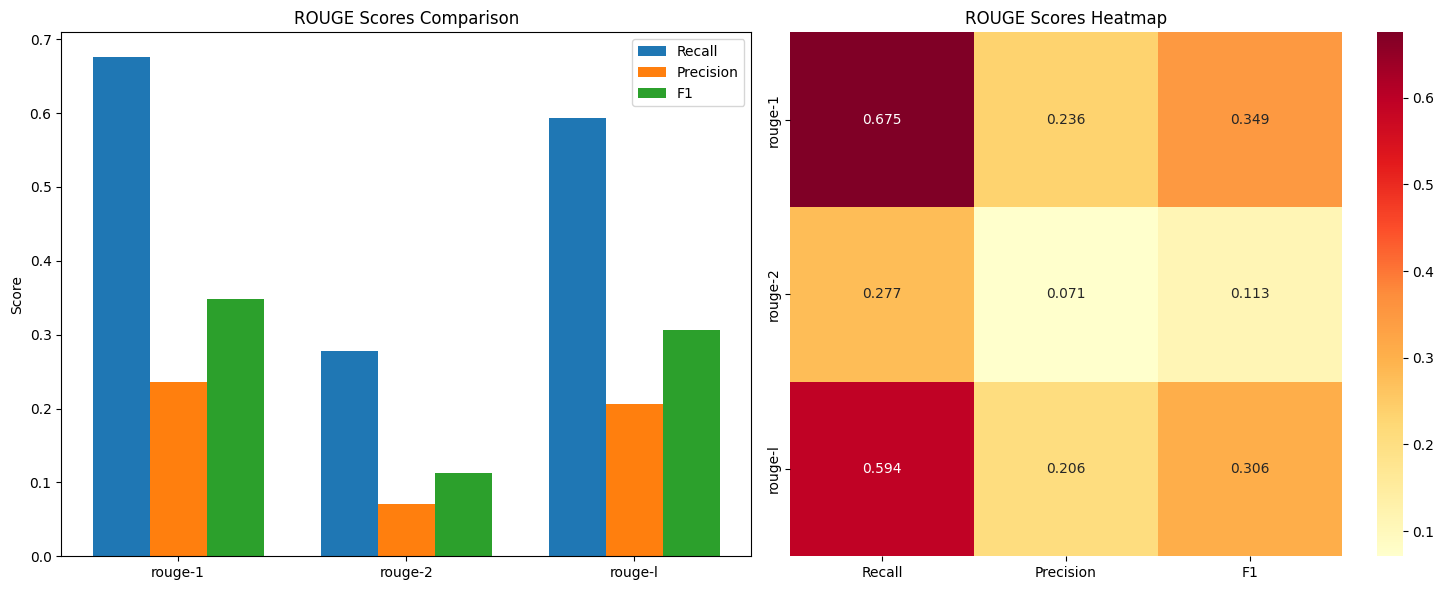


Summary Length Analysis:


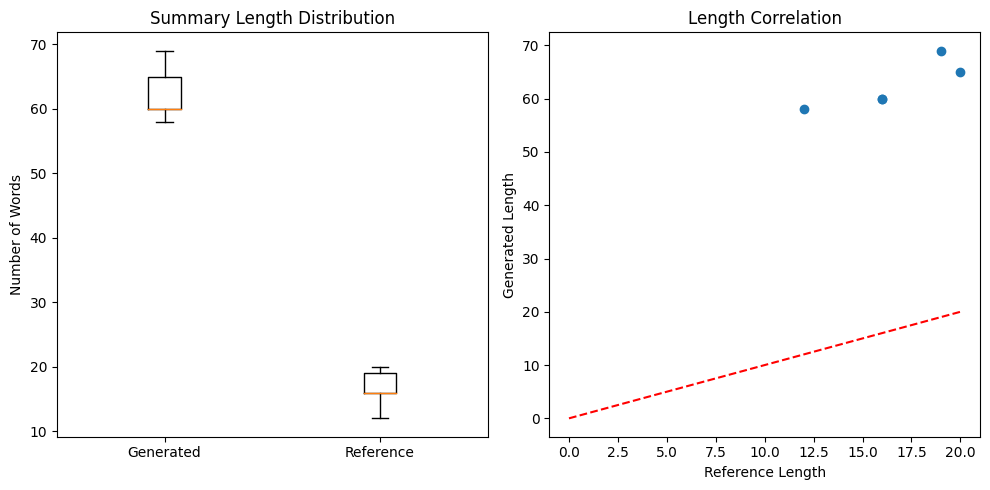


Length Statistics:
       Generated  Reference
count   5.000000   5.000000
mean   62.400000  16.600000
std     4.505552   3.130495
min    58.000000  12.000000
25%    60.000000  16.000000
50%    60.000000  16.000000
75%    65.000000  19.000000
max    69.000000  20.000000

Detailed Summary Comparison:

Summary 1:
Reference (20 words): Presiden Joko Widodo umumkan rencana pembangunan infrastruktur baru di Bali untuk mendukung pariwisata dan meningkatkan ekonomi dan kualitas hidup lokal.
Generated (65 words): [UNK] jakarta - presiden joko widodo hari ini mengumumkan rencana besar untuk pembangunan infrastruktur baru di pulau bali . proyek realistis ini , yang meliputi pembangunan jalan raya , jembatan , dan fasilitas umum , diharapkan dapat memberikan tekanan signifikan untuk industri pariwisata yang telah lama menjadi tulang punggung ekonomi bali . pembangunan ini juga bertujuan untuk meningkatkan kualitas hidup masyarakat lokal . . .
Length ratio: 3.25

Summary 2:
Reference (16 words): 

In [60]:
# Provide ROUGE scores
scores = {
    'rouge-1': {'r': 0.675438596491228, 'p': 0.23560248447204968, 'f': 0.3487004681939506},
    'rouge-2': {'r': 0.2774587985114301, 'p': 0.0710336276776116, 'f': 0.11272923355392658},
    'rouge-l': {'r': 0.593640350877193, 'p': 0.20649275362318836, 'f': 0.30585594063694055}
}

# 1. Create detailed visualization of ROUGE scores
def plot_rouge_scores(scores):
    rouge_types = list(scores.keys())
    metrics = {
        'Recall': [scores[rt]['r'] for rt in rouge_types],
        'Precision': [scores[rt]['p'] for rt in rouge_types],
        'F1': [scores[rt]['f'] for rt in rouge_types]
    }

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Bar plot
    x = np.arange(len(rouge_types))
    width = 0.25

    ax1.bar(x - width, metrics['Recall'], width, label='Recall')
    ax1.bar(x, metrics['Precision'], width, label='Precision')
    ax1.bar(x + width, metrics['F1'], width, label='F1')

    ax1.set_ylabel('Score')
    ax1.set_title('ROUGE Scores Comparison')
    ax1.set_xticks(x)
    ax1.set_xticklabels(rouge_types)
    ax1.legend()

    # Heatmap
    df_scores = pd.DataFrame(metrics, index=rouge_types)
    sns.heatmap(df_scores, annot=True, fmt='.3f', cmap='YlOrRd', ax=ax2)
    ax2.set_title('ROUGE Scores Heatmap')

    plt.tight_layout()
    plt.show()

# 2. Calculate and display summary statistics
def analyze_summaries(generated_summaries, reference_summaries):
    # Length analysis
    gen_lengths = [len(s.split()) for s in generated_summaries]
    ref_lengths = [len(s.split()) for s in reference_summaries]

    length_stats = pd.DataFrame({
        'Generated': gen_lengths,
        'Reference': ref_lengths
    }).describe()

    # Plot length comparison
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.boxplot([gen_lengths, ref_lengths], labels=['Generated', 'Reference'])
    plt.title('Summary Length Distribution')
    plt.ylabel('Number of Words')

    plt.subplot(1, 2, 2)
    plt.scatter(ref_lengths, gen_lengths)
    plt.plot([0, max(ref_lengths)], [0, max(ref_lengths)], 'r--')
    plt.xlabel('Reference Length')
    plt.ylabel('Generated Length')
    plt.title('Length Correlation')

    plt.tight_layout()
    plt.show()

    return length_stats

# 3. Print detailed comparison
def print_detailed_comparison(generated_summaries, reference_summaries):
    print("\nDetailed Summary Comparison:")
    print("=" * 80)

    for i, (gen, ref) in enumerate(zip(generated_summaries, reference_summaries), 1):
        print(f"\nSummary {i}:")
        print(f"Reference ({len(ref.split())} words): {ref}")
        print(f"Generated ({len(gen.split())} words): {gen}")
        print(f"Length ratio: {len(gen.split()) / len(ref.split()):.2f}")

# Run the analysis
print("ROUGE Score Analysis:")
plot_rouge_scores(scores)

print("\nSummary Length Analysis:")
length_stats = analyze_summaries(generated_summaries, reference_summaries)
print("\nLength Statistics:")
print(length_stats)

print_detailed_comparison(generated_summaries, reference_summaries)

# Print recommendations
print("\nAnalysis Recommendations:")
print("=" * 80)
if scores['rouge-1']['f'] > 0.3:
    print("✓ ROUGE-1 F1 score is acceptable")
else:
    print("! ROUGE-1 F1 score needs improvement")

if scores['rouge-2']['f'] > 0.1:
    print("✓ ROUGE-2 F1 score is acceptable")
else:
    print("! ROUGE-2 F1 score needs improvement")

if scores['rouge-l']['f'] > 0.25:
    print("✓ ROUGE-L F1 score is acceptable")
else:
    print("! ROUGE-L F1 score needs improvement")

## 7c. Advanced Model Evaluation Metrics

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Running comprehensive model evaluation...

Visualizing metrics...


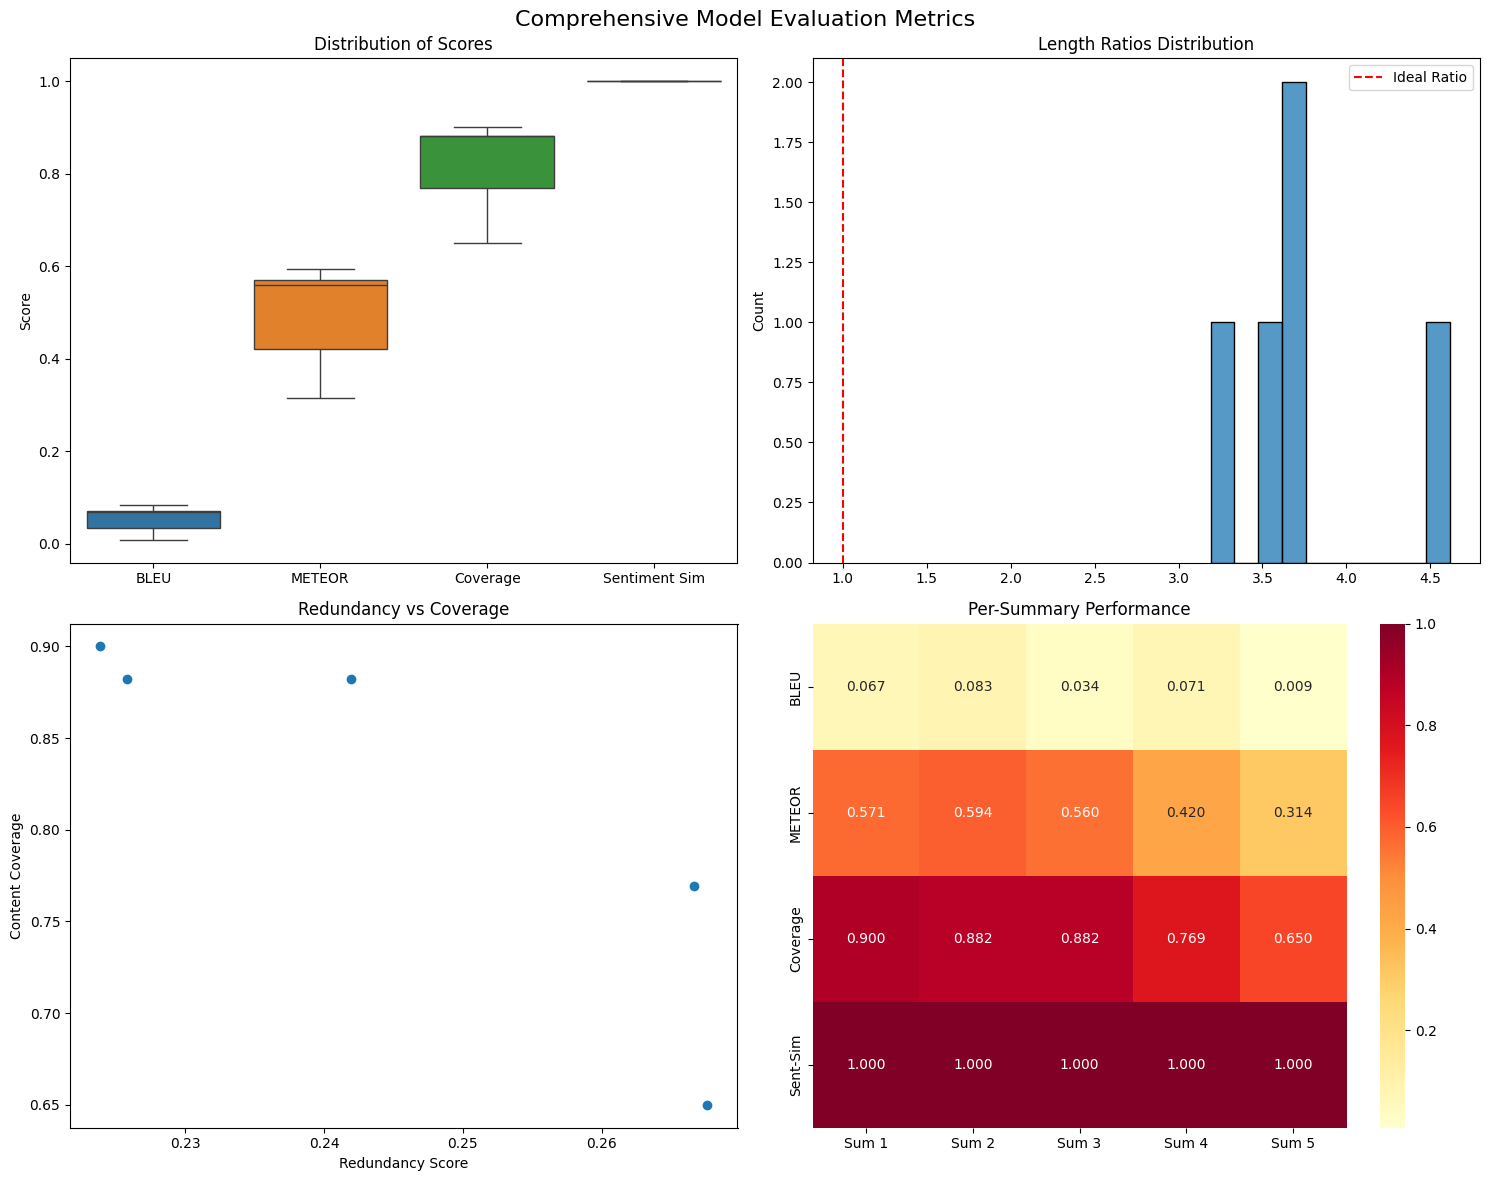


Printing detailed analysis...

Detailed Metrics Analysis:
       BLEU Score  METEOR Score  Content Coverage  Length Ratio  \
count    5.000000      5.000000          5.000000      5.000000   
mean     0.052800      0.491938          0.816787      3.729996   
std      0.030622      0.120447          0.106773      0.529422   
min      0.008641      0.314246          0.650000      3.190476   
25%      0.034052      0.420339          0.769231      3.550000   
50%      0.067328      0.560103          0.882353      3.647059   
75%      0.071155      0.570686          0.882353      3.647059   
max      0.082824      0.594315          0.900000      4.615385   

       Redundancy Score  Sentiment Similarity  
count          5.000000                   5.0  
mean           0.245179                   1.0  
std            0.021237                   0.0  
min            0.223881                   1.0  
25%            0.225806                   1.0  
50%            0.241935                   1.0  
7

In [62]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize
from nltk.translate.meteor_score import meteor_score
from textblob import TextBlob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Download required NLTK resources
nltk.download('punkt')
nltk.download('wordnet')

def calculate_extended_metrics(generated_summaries, reference_summaries):
    """Calculate comprehensive set of evaluation metrics"""

    metrics = {
        'bleu_scores': [],
        'meteor_scores': [],
        'length_ratios': [],
        'content_coverage': [],
        'readability_scores': [],
        'redundancy_scores': [],
        'sentiment_similarity': []
    }

    smoothie = SmoothingFunction().method1

    for gen, ref in zip(generated_summaries, reference_summaries):
        # 1. BLEU Score
        ref_tokens = [word_tokenize(ref.lower())]
        gen_tokens = word_tokenize(gen.lower())
        bleu = sentence_bleu(ref_tokens, gen_tokens, smoothing_function=smoothie)
        metrics['bleu_scores'].append(bleu)

        # 2. METEOR Score
        meteor = meteor_score([ref_tokens[0]], gen_tokens)
        metrics['meteor_scores'].append(meteor)

        # 3. Length Ratio
        length_ratio = len(gen_tokens) / len(ref_tokens[0])
        metrics['length_ratios'].append(length_ratio)

        # 4. Content Coverage
        ref_words = set(ref_tokens[0])
        gen_words = set(gen_tokens)
        coverage = len(gen_words.intersection(ref_words)) / len(ref_words)
        metrics['content_coverage'].append(coverage)

        # 5. Readability (TextBlob sentiment as proxy for clarity)
        readability = TextBlob(gen).sentiment.polarity
        metrics['readability_scores'].append(abs(readability))

        # 6. Redundancy Score (lower is better)
        word_freq = Counter(gen_tokens)
        redundancy = 1 - (len(set(gen_tokens)) / len(gen_tokens))
        metrics['redundancy_scores'].append(redundancy)

        # 7. Sentiment Similarity
        ref_sentiment = TextBlob(ref).sentiment.polarity
        gen_sentiment = TextBlob(gen).sentiment.polarity
        sentiment_sim = 1 - abs(ref_sentiment - gen_sentiment)
        metrics['sentiment_similarity'].append(sentiment_sim)

    return metrics

def plot_extended_metrics(metrics):
    """Create visualizations for all metrics"""

    # Create subplot grid
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Comprehensive Model Evaluation Metrics', fontsize=16)

    # 1. Score Distribution Plot
    df_metrics = pd.DataFrame({
        'BLEU': metrics['bleu_scores'],
        'METEOR': metrics['meteor_scores'],
        'Coverage': metrics['content_coverage'],
        'Sentiment Sim': metrics['sentiment_similarity']
    })

    sns.boxplot(data=df_metrics, ax=axes[0,0])
    axes[0,0].set_title('Distribution of Scores')
    axes[0,0].set_ylabel('Score')

    # 2. Length Ratio Plot
    sns.histplot(metrics['length_ratios'], ax=axes[0,1], bins=10)
    axes[0,1].set_title('Length Ratios Distribution')
    axes[0,1].axvline(1, color='r', linestyle='--', label='Ideal Ratio')
    axes[0,1].legend()

    # 3. Redundancy vs Coverage Plot
    axes[1,0].scatter(metrics['redundancy_scores'], metrics['content_coverage'])
    axes[1,0].set_xlabel('Redundancy Score')
    axes[1,0].set_ylabel('Content Coverage')
    axes[1,0].set_title('Redundancy vs Coverage')

    # 4. Summary Performance Heatmap
    summary_metrics = np.array([
        metrics['bleu_scores'],
        metrics['meteor_scores'],
        metrics['content_coverage'],
        metrics['sentiment_similarity']
    ])
    sns.heatmap(summary_metrics, ax=axes[1,1],
                xticklabels=[f'Sum {i+1}' for i in range(len(generated_summaries))],
                yticklabels=['BLEU', 'METEOR', 'Coverage', 'Sent-Sim'],
                cmap='YlOrRd', annot=True, fmt='.3f')
    axes[1,1].set_title('Per-Summary Performance')

    plt.tight_layout()
    plt.show()

def print_detailed_metrics(metrics):
    """Print detailed analysis of all metrics"""

    print("\nDetailed Metrics Analysis:")
    print("=" * 80)

    metrics_summary = {
        'BLEU Score': metrics['bleu_scores'],
        'METEOR Score': metrics['meteor_scores'],
        'Content Coverage': metrics['content_coverage'],
        'Length Ratio': metrics['length_ratios'],
        'Redundancy Score': metrics['redundancy_scores'],
        'Sentiment Similarity': metrics['sentiment_similarity']
    }

    df_summary = pd.DataFrame(metrics_summary).describe()
    print(df_summary)

    print("\nMetric Correlations:")
    print("-" * 80)
    df_corr = pd.DataFrame(metrics_summary).corr()
    print(df_corr)

def provide_recommendations(metrics):
    """Provide specific recommendations based on metrics"""

    print("\nModel Performance Analysis and Recommendations:")
    print("=" * 80)

    # BLEU Score Analysis
    avg_bleu = np.mean(metrics['bleu_scores'])
    if avg_bleu < 0.3:
        print("❗ BLEU Score is low. Consider:")
        print("  - Fine-tuning with focus on n-gram preservation")
        print("  - Adjusting beam search parameters")
    else:
        print("✓ BLEU Score is acceptable")

    # Content Coverage Analysis
    avg_coverage = np.mean(metrics['content_coverage'])
    if avg_coverage < 0.7:
        print("\n❗ Content coverage could be improved:")
        print("  - Review max_length parameters")
        print("  - Consider adjusting minimum length constraints")
    else:
        print("\n✓ Content coverage is good")

    # Redundancy Analysis
    avg_redundancy = np.mean(metrics['redundancy_scores'])
    if avg_redundancy > 0.2:
        print("\n❗ High redundancy detected:")
        print("  - Consider implementing no-repeat ngram size")
        print("  - Adjust beam search diversity penalties")
    else:
        print("\n✓ Redundancy is well controlled")

    # Length Ratio Analysis
    avg_length_ratio = np.mean(metrics['length_ratios'])
    if abs(avg_length_ratio - 1) > 0.3:
        print("\n❗ Summary length ratio needs adjustment:")
        print(f"  - Current average ratio: {avg_length_ratio:.2f}")
        print("  - Consider adjusting min/max length parameters")
    else:
        print("\n✓ Length ratio is appropriate")

# Run the comprehensive evaluation
print("Running comprehensive model evaluation...")
extended_metrics = calculate_extended_metrics(generated_summaries, reference_summaries)

print("\nVisualizing metrics...")
plot_extended_metrics(extended_metrics)

print("\nPrinting detailed analysis...")
print_detailed_metrics(extended_metrics)

print("\nGenerating recommendations...")
provide_recommendations(extended_metrics)

# Test Model

In [63]:
# Load model and tokenizer
tokenizer = BertTokenizer.from_pretrained("cahya/bert2gpt-indonesian-summarization")
tokenizer.bos_token = tokenizer.cls_token
tokenizer.eos_token = tokenizer.sep_token
model_path = "/content/drive/MyDrive/results_continued/checkpoint-4846"
model = EncoderDecoderModel.from_pretrained(model_path)

# Test articles with reference summaries
test_articles = {
    'article1': {
        'text': '''Liputan6.com, Jakarta: Tentara Nasional Indonesia hendaknya benar-benar profesional. TNI juga harus berada di atas seluruh kekuatan politik yang ada. Demikian permintaan mantan Presiden Partai Keadilan Sejahtera Hidayat Nur Wahid, di sela-sela Munas PKS, Sabtu (19/6), di Jakarta. TNI adalah alat negara yang harus netral dan berada di atas seluruh kekuatan politik yang ada. Ini untuk menjaga keamanan teritorial dan keutuhan Negara Kesatuan Republik Indonesia, kata Hidayat, seperti ditulis Antara. Menurut Hidayat, TNI baru mungkin memiliki hak pilih pada pemilu jika diatur secara konstitusional melalui perundang-undangan. Saya kira wacana TNI memiliki hak pilih dalam pemilu harus melalui pembahasan lebih lanjut di DPR, ujar anggota Komisi I DPR RI itu. Dari pembicaraan dengan pimpinan TNI, kata Hidayat, sampai saat ini TNI masih memilih belum terlibat di pemilu. Hal ini belajar dari pengalaman pada pemilu 1955, di mana TNI terlibat di pemilu sehingga terbelah pada sejumlah kekuatan politik. Kondisi ini membuat sistem keamanan nasional menjadi tidak optimal. Sebelumnya, Presiden Susilo Bambang Yudhoyono mengatakan, suatu saat TNI harus diberikan haknya untuk memberikan hak suara pada pemilu jika sudah tidak ada hambatan yang mengganggu kekompakan. Bisa tidaknya anggota TNI menggunakan hak pilihnya dalam pemilu maupun pilkada, kata Presiden, dapat ditentukan oleh undang-undang yang dibahas oleh pemerintah bersama DPR.''',
        'reference': 'TNI harus profesional dan netral dalam politik. Pemberian hak pilih TNI dalam pemilu perlu diatur melalui undang-undang.'
    },
    'article2': {
        'text': '''Liputan6.com, Jakarta: Partai Keadilan Sejahtera (PKS) mendukung upaya pemerintah memberantas korupsi. Namun, PKS mengingatkan agar pemerintah tidak tebang pilih dalam menindak para koruptor. "Kami mendukung upaya pemberantasan korupsi yang dilakukan pemerintah. Tapi, kami minta agar penegakan hukum dilakukan secara adil dan tidak tebang pilih," kata Ketua DPP PKS Hidayat Nur Wahid di Jakarta, Jumat (18/6). PKS juga meminta KPK untuk lebih aktif dalam menangani kasus-kasus korupsi besar yang merugikan negara. "KPK harus fokus pada kasus-kasus besar yang merugikan keuangan negara," ujarnya.''',
        'reference': 'PKS mendukung pemberantasan korupsi dan meminta penegakan hukum dilakukan secara adil tanpa tebang pilih.'
    }
}

def generate_summary(article):
    """Generate summary using the model"""
    input_ids = tokenizer.encode(article, return_tensors='pt')
    summary_ids = model.generate(
        input_ids,
        min_length=20,
        max_length=80,
        num_beams=10,
        repetition_penalty=2.5,
        length_penalty=1.0,
        early_stopping=True,
        no_repeat_ngram_size=2,
        use_cache=True,
        do_sample=True,
        temperature=0.3,
        top_k=50,
        top_p=0.95
    )
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

def evaluate_summary(generated, reference):
    """Calculate evaluation metrics"""
    rouge = Rouge()
    rouge_scores = rouge.get_scores(generated, reference)[0]

    # Calculate BLEU score
    reference_tokens = [word_tokenize(reference)]
    generated_tokens = word_tokenize(generated)
    bleu_score = sentence_bleu(reference_tokens, generated_tokens)

    # Calculate length ratio
    length_ratio = len(generated.split()) / len(reference.split())

    return {
        'rouge-1-f': rouge_scores['rouge-1']['f'],
        'rouge-2-f': rouge_scores['rouge-2']['f'],
        'rouge-l-f': rouge_scores['rouge-l']['f'],
        'bleu': bleu_score,
        'length_ratio': length_ratio
    }

# Run tests and collect results
results = []
print("Running model tests...")
print("-" * 80)

for article_id, article_data in test_articles.items():
    print(f"\nTesting {article_id}:")
    print("Original text length:", len(article_data['text'].split()))

    # Generate summary
    generated_summary = generate_summary(article_data['text'])
    print("\nGenerated summary:", generated_summary)
    print("Reference summary:", article_data['reference'])

    # Evaluate
    metrics = evaluate_summary(generated_summary, article_data['reference'])
    metrics['article_id'] = article_id
    metrics['generated'] = generated_summary
    metrics['reference'] = article_data['reference']
    results.append(metrics)

    print("\nMetrics:")
    for metric, value in metrics.items():
        if metric not in ['article_id', 'generated', 'reference']:
            print(f"{metric}: {value:.4f}")
    print("-" * 80)

# Create results DataFrame
results_df = pd.DataFrame(results)

# Print average metrics
print("\nAverage Metrics Across All Tests:")
print(results_df[['rouge-1-f', 'rouge-2-f', 'rouge-l-f', 'bleu', 'length_ratio']].mean())

# Print recommendations
print("\nRecommendations:")
avg_metrics = results_df[['rouge-1-f', 'rouge-2-f', 'rouge-l-f', 'bleu', 'length_ratio']].mean()

if avg_metrics['rouge-1-f'] < 0.3:
    print("- Consider improving content preservation")
if avg_metrics['rouge-2-f'] < 0.1:
    print("- Focus on improving phrase-level accuracy")
if avg_metrics['length_ratio'] > 2:
    print("- Adjust length penalties to generate more concise summaries")
if avg_metrics['bleu'] < 0.1:
    print("- Review beam search parameters for better fluency")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Running model tests...
--------------------------------------------------------------------------------

Testing article1:
Original text length: 203


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Generated summary: [UNK] mantan presiden pks hidayat nur wahid mengatakan, tni adalah alat negara yang harus netral dan berada di atas seluruh kekuatan politik yang ada. ini untuk menjaga keamanan teritorial dan keutuhan negara kesatuan republik indonesia. kata hidayat, anggota komisi i dpr ri itu. akan ditentukan oleh undang - undangnya dalam pemilu atau pilkada jika sudah tidak ada hambatan yang mengganggu kekesalan. apa pun terjadi di dpr?
Reference summary: TNI harus profesional dan netral dalam politik. Pemberian hak pilih TNI dalam pemilu perlu diatur melalui undang-undang.

Metrics:
rouge-1-f: 0.1600
rouge-2-f: 0.0247
rouge-l-f: 0.1600
bleu: 0.0000
length_ratio: 3.8824
--------------------------------------------------------------------------------

Testing article2:
Original text length: 81

Generated summary: [UNK] pks mengingatkan agar pemerintah tidak tebang pilih dalam menindak para koruptor. pks juga meminta kpk lebih aktif dalam menangani kasus - kasus korupsi besar yang